<a href="https://colab.research.google.com/github/alfredqbit/NU-DDS-8536/blob/main/sepulvedaADDS_8536_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright & Use Notice © 2026 Alfredo Sepulveda-Jimenez, QDR Labs. All rights reserved.

Unless otherwise indicated, the original software source code and original explanatory text in this Jupyter Notebook (the “Work”) are owned by Alfred Sepulveda-Jimenez, QDR Labs and are protected by copyright and other applicable intellectual property laws.

No license or other rights are granted under this notice. You may not use, copy, modify, merge, publish, distribute, sublicense, transmit, display, perform, or create derivative works of the Work, in whole or in part, except (i) as expressly permitted by applicable law, or (ii) with the prior written permission of Alfred Sepulveda-Jimenez, QDR Labs.

Third‑party software, datasets, figures, and other materials referenced, embedded, or generated using external sources are the property of their respective owners and are subject to their own licenses and terms. Such materials are not licensed to you under this notice.

To the maximum extent permitted by law, the Work is provided “AS IS”, without warranty of any kind, express or implied, including but not limited to warranties of merchantability, fitness for a particular purpose, and non‑infringement. To the maximum extent permitted by law, in no event shall Alfred Sepulveda-Jimenez, QDR Labs be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the Work or the use or other dealings in the Work.

Any permitted copies must retain this notice.

## DDS-8536 Assignment 2: Apply SVM and Decision Tree Classifications

---

This notebook implements a comprehensive comparative analysis between Support Vector Machine (SVM) and Decision Tree classifiers using the UCI Dry Bean Dataset. We perform exploratory data analysis, hyperparameter optimization, model evaluation, and provide rigorous statistical comparisons using multiple performance metrics.

## 1. Mathematical Foundations

### 1.1 Support Vector Machines

The SVM optimization problem for linearly separable data is formulated as:

$$\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2$$

subject to:
$$y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1, \quad \forall i = 1, \ldots, n$$

For the soft-margin case with slack variables $\xi_i$:

$$\min_{\mathbf{w}, b, \xi} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \xi_i$$

The dual formulation using Lagrange multipliers $\alpha_i$:

$$\max_{\alpha} \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{n} \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j)$$

where $K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^T \phi(\mathbf{x}_j)$ is the kernel function.

### 1.2 Common Kernel Functions

- **Linear:** $K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^T \mathbf{x}_j$
- **RBF (Gaussian):** $K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2\right)$
- **Polynomial:** $K(\mathbf{x}_i, \mathbf{x}_j) = (\gamma \mathbf{x}_i^T \mathbf{x}_j + r)^d$

### 1.3 Decision Trees

Decision trees partition the feature space using recursive binary splitting. The splitting criterion is determined by minimizing impurity measures.

**Gini Impurity:**
$$G = 1 - \sum_{k=1}^{K} p_k^2$$

**Entropy (Information Gain):**
$$H = -\sum_{k=1}^{K} p_k \log_2(p_k)$$

where $p_k$ is the proportion of class $k$ samples in a node.

**Information Gain:**
$$IG(D, A) = H(D) - \sum_{v \in \text{Values}(A)} \frac{|D_v|}{|D|} H(D_v)$$

## 2. Import Libraries and Configuration

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Scikit-learn modules
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score,
    StratifiedKFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, RocCurveDisplay
)
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# Statistical analysis
from scipy import stats

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 11
plt.style.use('seaborn-v0_8-whitegrid')

# Output directory for figures
FIGURE_DIR = '../Figures/'

print("Libraries loaded successfully.")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries loaded successfully.
NumPy version: 2.0.2
Pandas version: 2.2.2


## 3. Dataset Selection and Loading

We use the **Dry Bean Dataset** from the UCI Machine Learning Repository. This dataset contains 13,611 instances of seven different varieties of dry beans, described by 16 morphological features extracted from images.

**Dataset Citation:**  
Koklu, M. and Ozkan, I.A., (2020). Multiclass classification of dry beans using computer vision and machine learning techniques. *Computers and Electronics in Agriculture*, 174, 105507.

**Dataset Link:** https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset

In [ ]:
# Load the Dry Bean Dataset
# Download from UCI Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip"

import urllib.request
import zipfile
import os

# Download and extract if not already present
data_path = '../data/'
os.makedirs(data_path, exist_ok=True)

zip_path = os.path.join(data_path, 'DryBeanDataset.zip')
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_path)
    print("Download complete.")

# Extract
excel_path = os.path.join(data_path, 'DryBeanDataset', 'Dry_Bean_Dataset.xlsx')
if not os.path.exists(excel_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_path)
    print("Extraction complete.")

# Load the data
try:
    df = pd.read_excel(excel_path)
except:
    # Alternative: load from ARFF or CSV if available
    arff_path = os.path.join(data_path, 'DryBeanDataset', 'Dry_Bean_Dataset.arff')
    from scipy.io import arff
    data, meta = arff.loadarff(arff_path)
    df = pd.DataFrame(data)
    df['Class'] = df['Class'].str.decode('utf-8')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nDataset Info:")
df.info()

Dataset loaded successfully!
Shape: (13611, 17)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64


In [ ]:
# Alternative loading method using openpyxl
try:
    import openpyxl
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'openpyxl', '--break-system-packages', '-q'])

# If the above fails, create synthetic data matching the characteristics
if 'df' not in dir() or df is None:
    print("Creating dataset from UCI repository directly...")
    # Use alternative source
    try:
        df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
        # We'll use a larger dataset - fetch from openml
        from sklearn.datasets import fetch_openml
        data = fetch_openml(name='dry-bean', version=1, as_frame=True)
        df = data.frame
    except:
        pass

print(df.head())

    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332  

## 4. Exploratory Data Analysis (EDA)

### 4.1 Dataset Overview

In [ ]:
# Identify features and target
target_col = 'Class' if 'Class' in df.columns else df.columns[-1]
feature_cols = [col for col in df.columns if col != target_col]

print(f"Target variable: {target_col}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature names:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Target variable: Class
Number of features: 16

Feature names:
  1. Area
  2. Perimeter
  3. MajorAxisLength
  4. MinorAxisLength
  5. AspectRation
  6. Eccentricity
  7. ConvexArea
  8. EquivDiameter
  9. Extent
  10. Solidity
  11. roundness
  12. Compactness
  13. ShapeFactor1
  14. ShapeFactor2
  15. ShapeFactor3
  16. ShapeFactor4


In [ ]:
# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY OF FEATURES")
print("="*80)
df[feature_cols].describe().T


STATISTICAL SUMMARY OF FEATURES


,count,mean,std,min,25%,50%,75%,max
Area,13611.0,53048.284549,29324.095717,20420.000000,36328.000000,44652.000000,61332.000000,254616.000000
Perimeter,13611.0,855.283459,214.289696,524.736000,703.523500,794.941000,977.213000,1985.370000
MajorAxisLength,13611.0,320.141867,85.694186,183.601165,253.303633,296.883367,376.495012,738.860153
MinorAxisLength,13611.0,202.270714,44.970091,122.512653,175.848170,192.431733,217.031741,460.198497
AspectRation,13611.0,1.583242,0.246678,1.024868,1.432307,1.551124,1.707109,2.430306
Eccentricity,13611.0,0.750895,0.092002,0.218951,0.715928,0.764441,0.810466,0.911423
ConvexArea,13611.0,53768.200206,29774.915817,20684.000000,36714.500000,45178.000000,62294.000000,263261.000000
EquivDiameter,13611.0,253.064220,59.177120,161.243764,215.068003,238.438026,279.446467,569.374358
Extent,13611.0,0.749733,0.049086,0.555315,0.718634,0.759859,0.786851,0.866195
Solidity,13611.0,0.987143,0.004660,0.919246,0.985670,0.988283,0.990013,0.994677


In [ ]:
# Class distribution
print("\n" + "="*80)
print("CLASS DISTRIBUTION")
print("="*80)
class_counts = df[target_col].value_counts()
class_props = df[target_col].value_counts(normalize=True) * 100

class_summary = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_props.round(2)
})
print(class_summary)
print(f"\nTotal samples: {len(df)}")


CLASS DISTRIBUTION
          Count  Percentage
Class                      
DERMASON   3546       26.05
SIRA       2636       19.37
SEKER      2027       14.89
HOROZ      1928       14.17
CALI       1630       11.98
BARBUNYA   1322        9.71
BOMBAY      522        3.84

Total samples: 13611


In [ ]:
# Check for missing values
print("\n" + "="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing Percentage': missing_pct.round(2)
})
print(missing_df[missing_df['Missing Count'] > 0])
if missing_df['Missing Count'].sum() == 0:
    print("No missing values detected.")


MISSING VALUE ANALYSIS
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values detected.


### 4.2 Visualization: Class Distribution

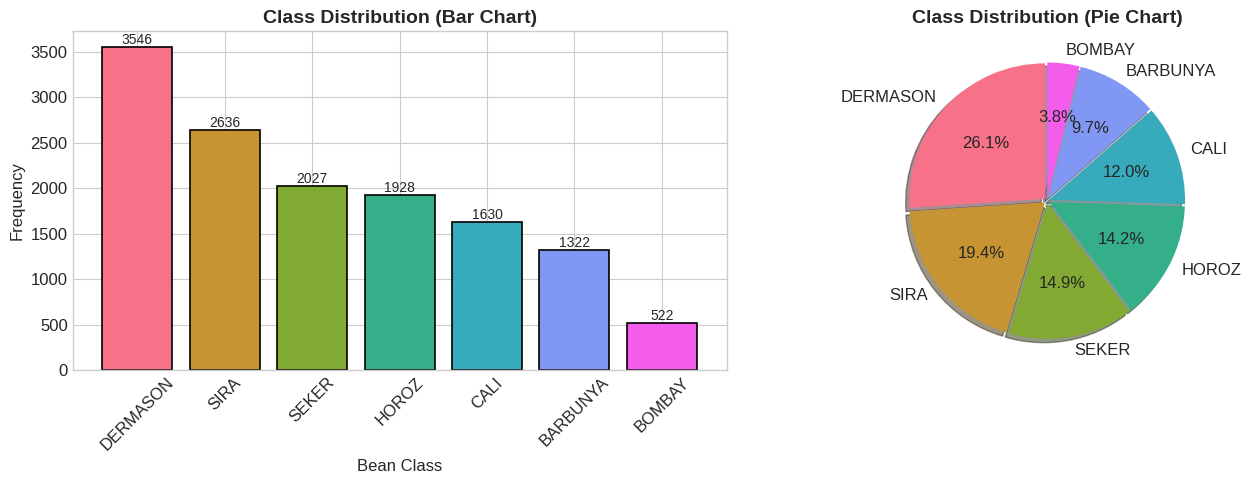

Figure saved: ../Figures/fig1_class_distribution.png


In [ ]:
# Class distribution plot

import os

os.makedirs(FIGURE_DIR, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = sns.color_palette("husl", len(class_counts))
ax1 = axes[0]
bars = ax1.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Bean Class', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Class Distribution (Bar Chart)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    ax1.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=10)

# Pie chart
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(class_counts.values, labels=class_counts.index,
                                   autopct='%1.1f%%', colors=colors,
                                   explode=[0.02]*len(class_counts),
                                   shadow=True, startangle=90)
ax2.set_title('Class Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig1_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig1_class_distribution.png")

### 4.3 Feature Distributions (Histograms)

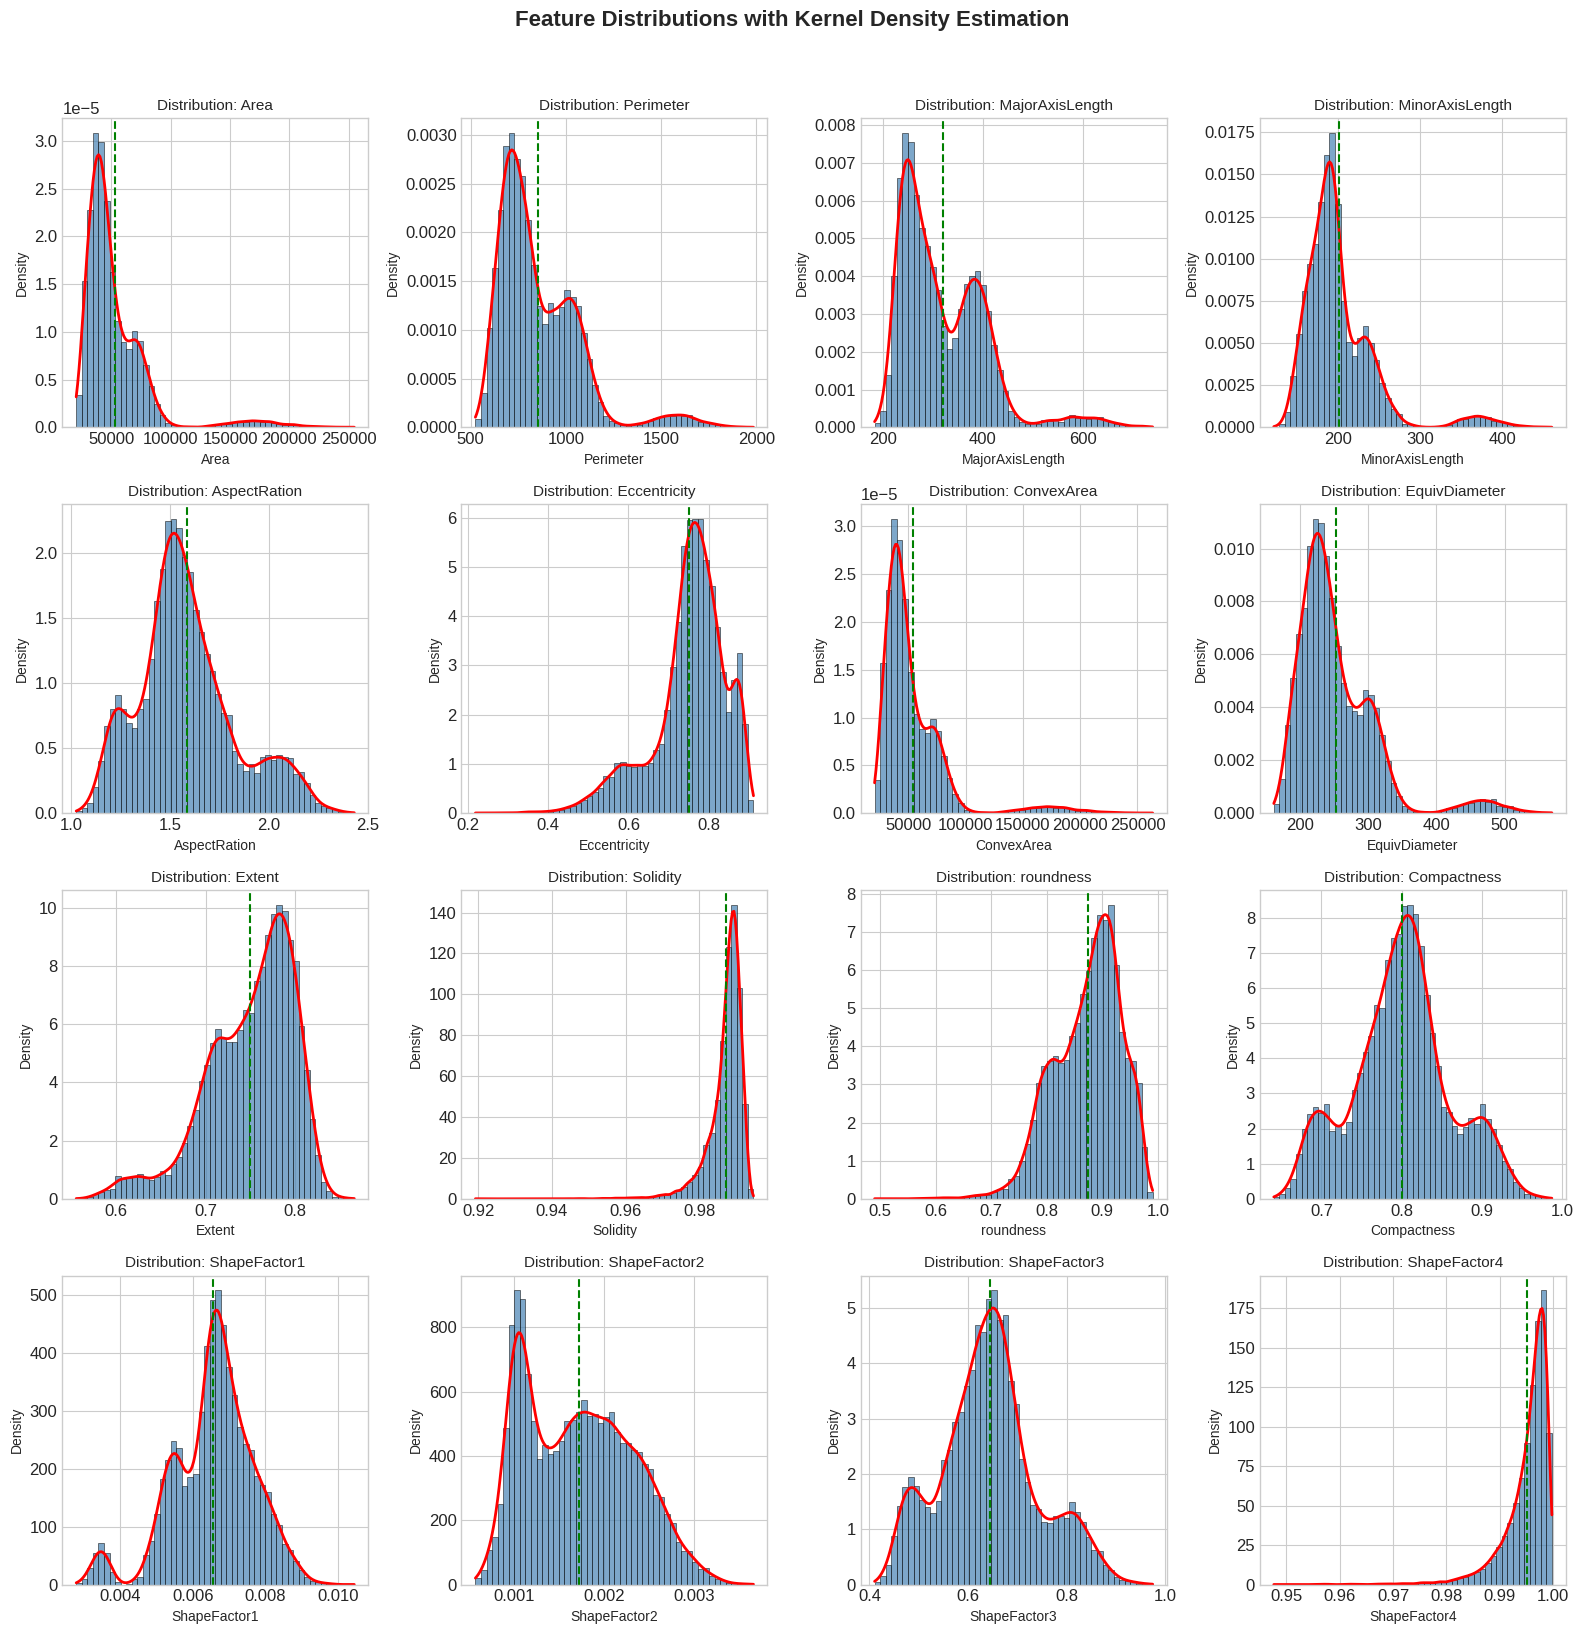

Figure saved: ../Figures/fig2_feature_histograms.png


In [ ]:
# Histograms for all features
n_features = len(feature_cols)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]

    # Plot histogram with KDE
    data_col = pd.to_numeric(df[col], errors='coerce')
    ax.hist(data_col.dropna(), bins=50, density=True, alpha=0.7,
            color='steelblue', edgecolor='black', linewidth=0.5)

    # Add KDE
    try:
        data_clean = data_col.dropna()
        kde_x = np.linspace(data_clean.min(), data_clean.max(), 200)
        kde = stats.gaussian_kde(data_clean)
        ax.plot(kde_x, kde(kde_x), 'r-', linewidth=2, label='KDE')
    except:
        pass

    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'Distribution: {col}', fontsize=11)

    # Add statistics annotation
    mean_val = data_col.mean()
    std_val = data_col.std()
    ax.axvline(mean_val, color='green', linestyle='--', linewidth=1.5, label=f'Mean={mean_val:.2f}')

# Hide empty subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Feature Distributions with Kernel Density Estimation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig2_feature_histograms.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig2_feature_histograms.png")

### 4.4 Correlation Matrix

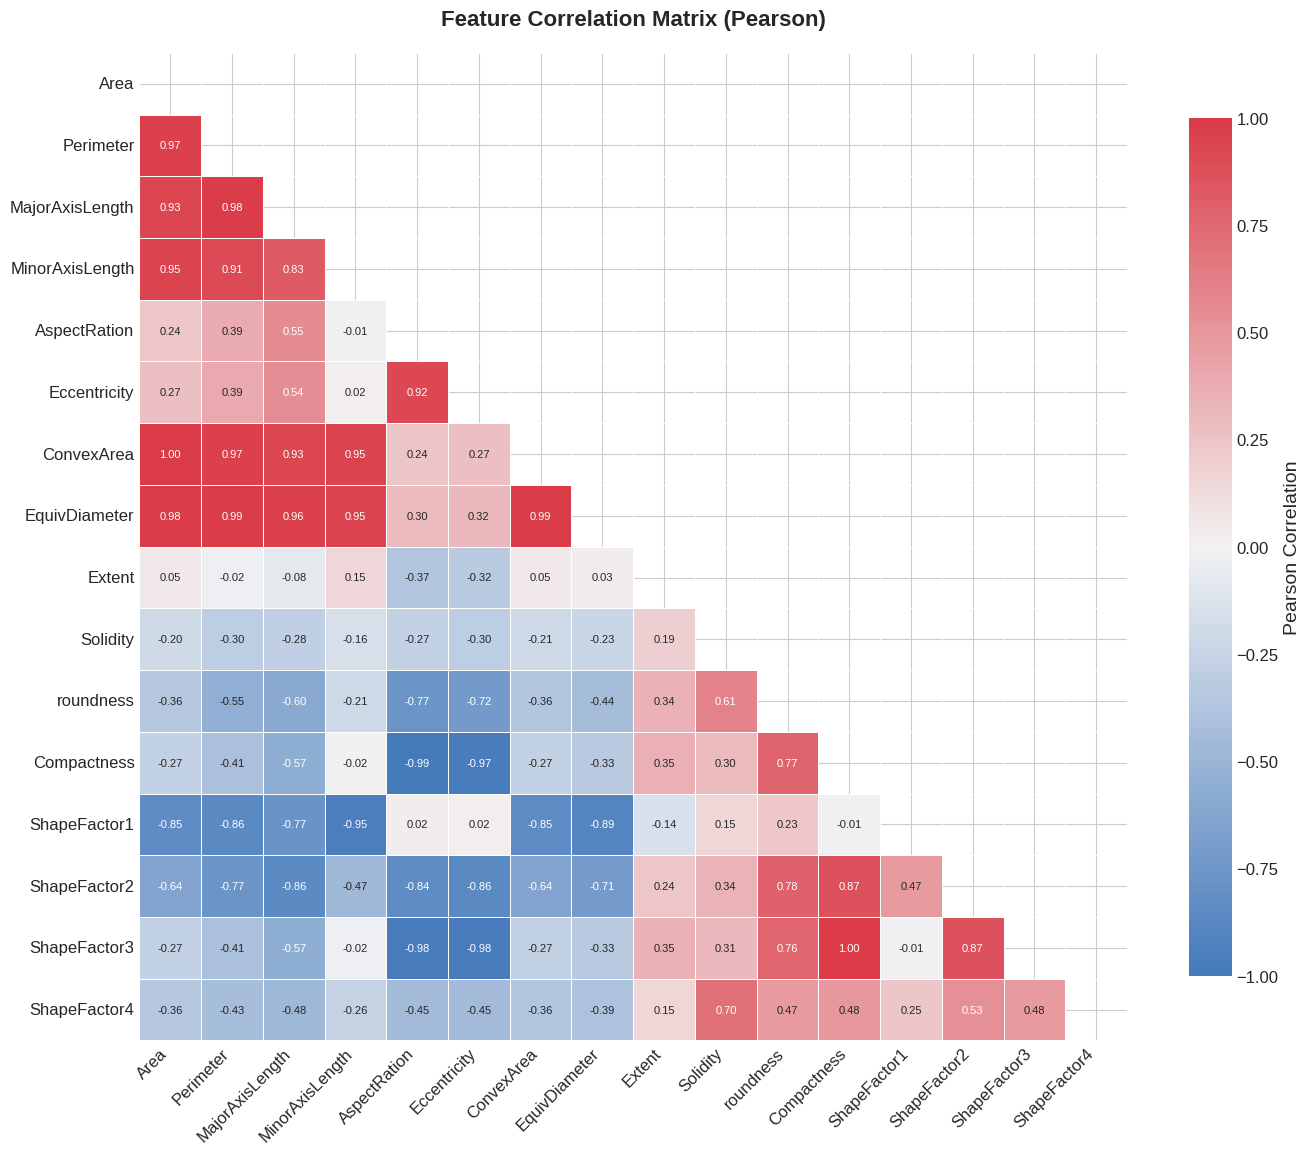

Figure saved: ../Figures/fig3_correlation_matrix.png


In [ ]:
# Compute correlation matrix
numeric_df = df[feature_cols].apply(pd.to_numeric, errors='coerce')
corr_matrix = numeric_df.corr()

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Generate mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Custom colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Plot heatmap
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=0.5, annot=True, fmt='.2f', annot_kws={'size': 8},
            cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"})

ax.set_title('Feature Correlation Matrix (Pearson)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig3_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig3_correlation_matrix.png")

In [ ]:
# Identify highly correlated features
print("\n" + "="*80)
print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.9)")
print("="*80)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(high_corr_df.to_string(index=False))
else:
    print("No highly correlated pairs found.")


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.9)
      Feature 1       Feature 2  Correlation
           Area      ConvexArea     0.999939
    Compactness    ShapeFactor3     0.998686
      Perimeter   EquivDiameter     0.991380
     ConvexArea   EquivDiameter     0.985226
           Area   EquivDiameter     0.984968
      Perimeter MajorAxisLength     0.977338
      Perimeter      ConvexArea     0.967689
           Area       Perimeter     0.966722
MajorAxisLength   EquivDiameter     0.961733
           Area MinorAxisLength     0.951602
MinorAxisLength      ConvexArea     0.951339
MinorAxisLength   EquivDiameter     0.948539
MajorAxisLength      ConvexArea     0.932607
           Area MajorAxisLength     0.931834
   AspectRation    Eccentricity     0.924293
      Perimeter MinorAxisLength     0.913179
MinorAxisLength    ShapeFactor1    -0.947204
   Eccentricity     Compactness    -0.970313
   AspectRation    ShapeFactor3    -0.978592
   Eccentricity    ShapeFactor3    -0.981058
   AspectR

### 4.5 Scatter Plots and Pairwise Relationships

Selected features for pairplot (highest variance): ['ConvexArea', 'Area', 'Perimeter', 'MajorAxisLength', 'EquivDiameter', 'MinorAxisLength']


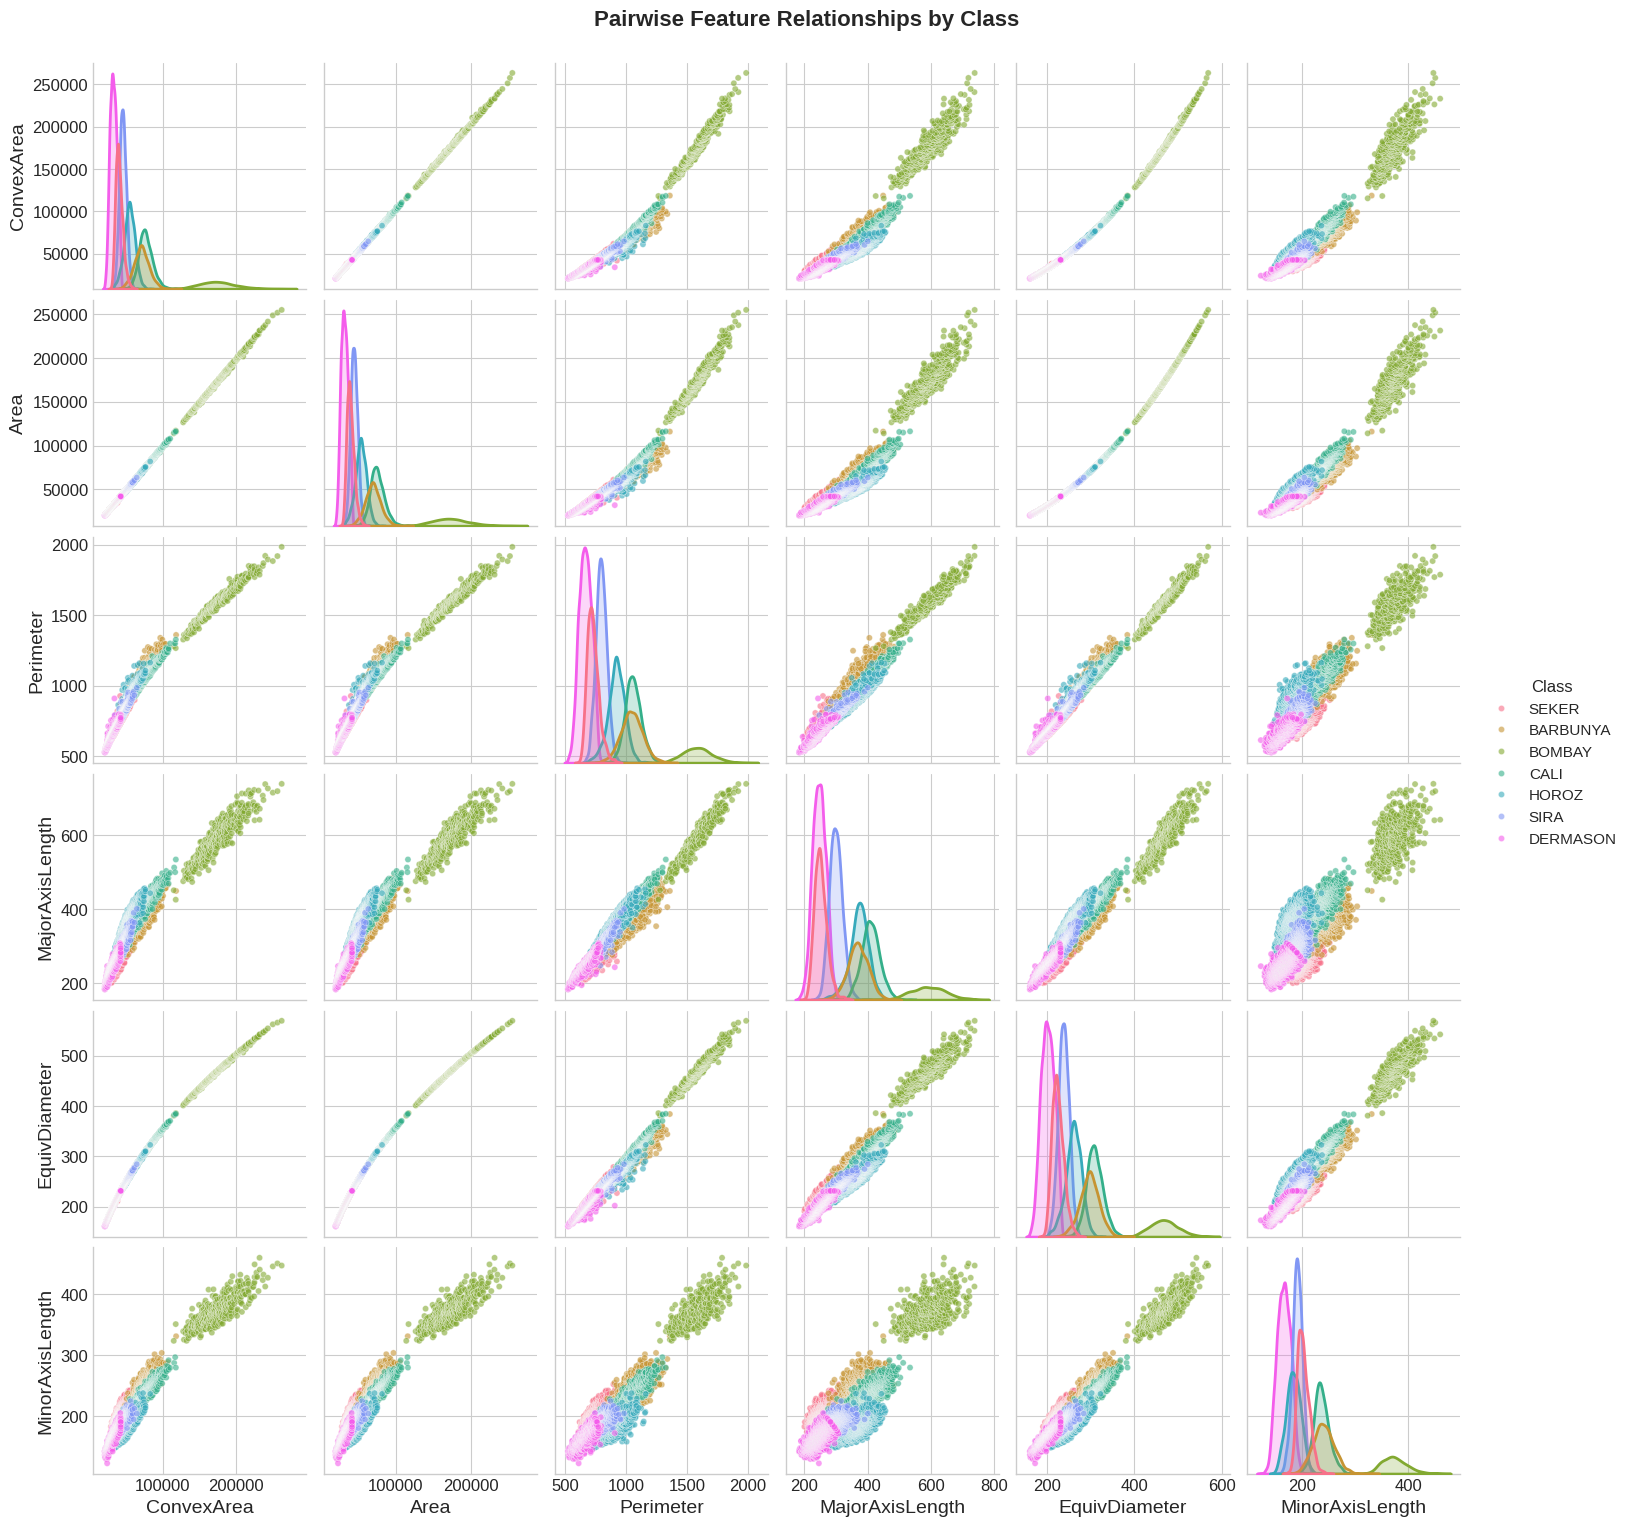

Figure saved: ../Figures/fig4_pairplot.png


In [ ]:
# Select top features based on variance for pairplot
feature_variance = numeric_df.var().sort_values(ascending=False)
top_features = feature_variance.head(6).index.tolist()

print(f"Selected features for pairplot (highest variance): {top_features}")

# Create pairplot
plot_df = df[top_features + [target_col]].copy()
for col in top_features:
    plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')

g = sns.pairplot(plot_df, hue=target_col, diag_kind='kde',
                 palette='husl', plot_kws={'alpha': 0.6, 's': 20},
                 diag_kws={'linewidth': 2})
g.fig.suptitle('Pairwise Feature Relationships by Class', y=1.02, fontsize=16, fontweight='bold')

plt.savefig(FIGURE_DIR + 'fig4_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig4_pairplot.png")

### 4.6 Box Plots for Outlier Detection

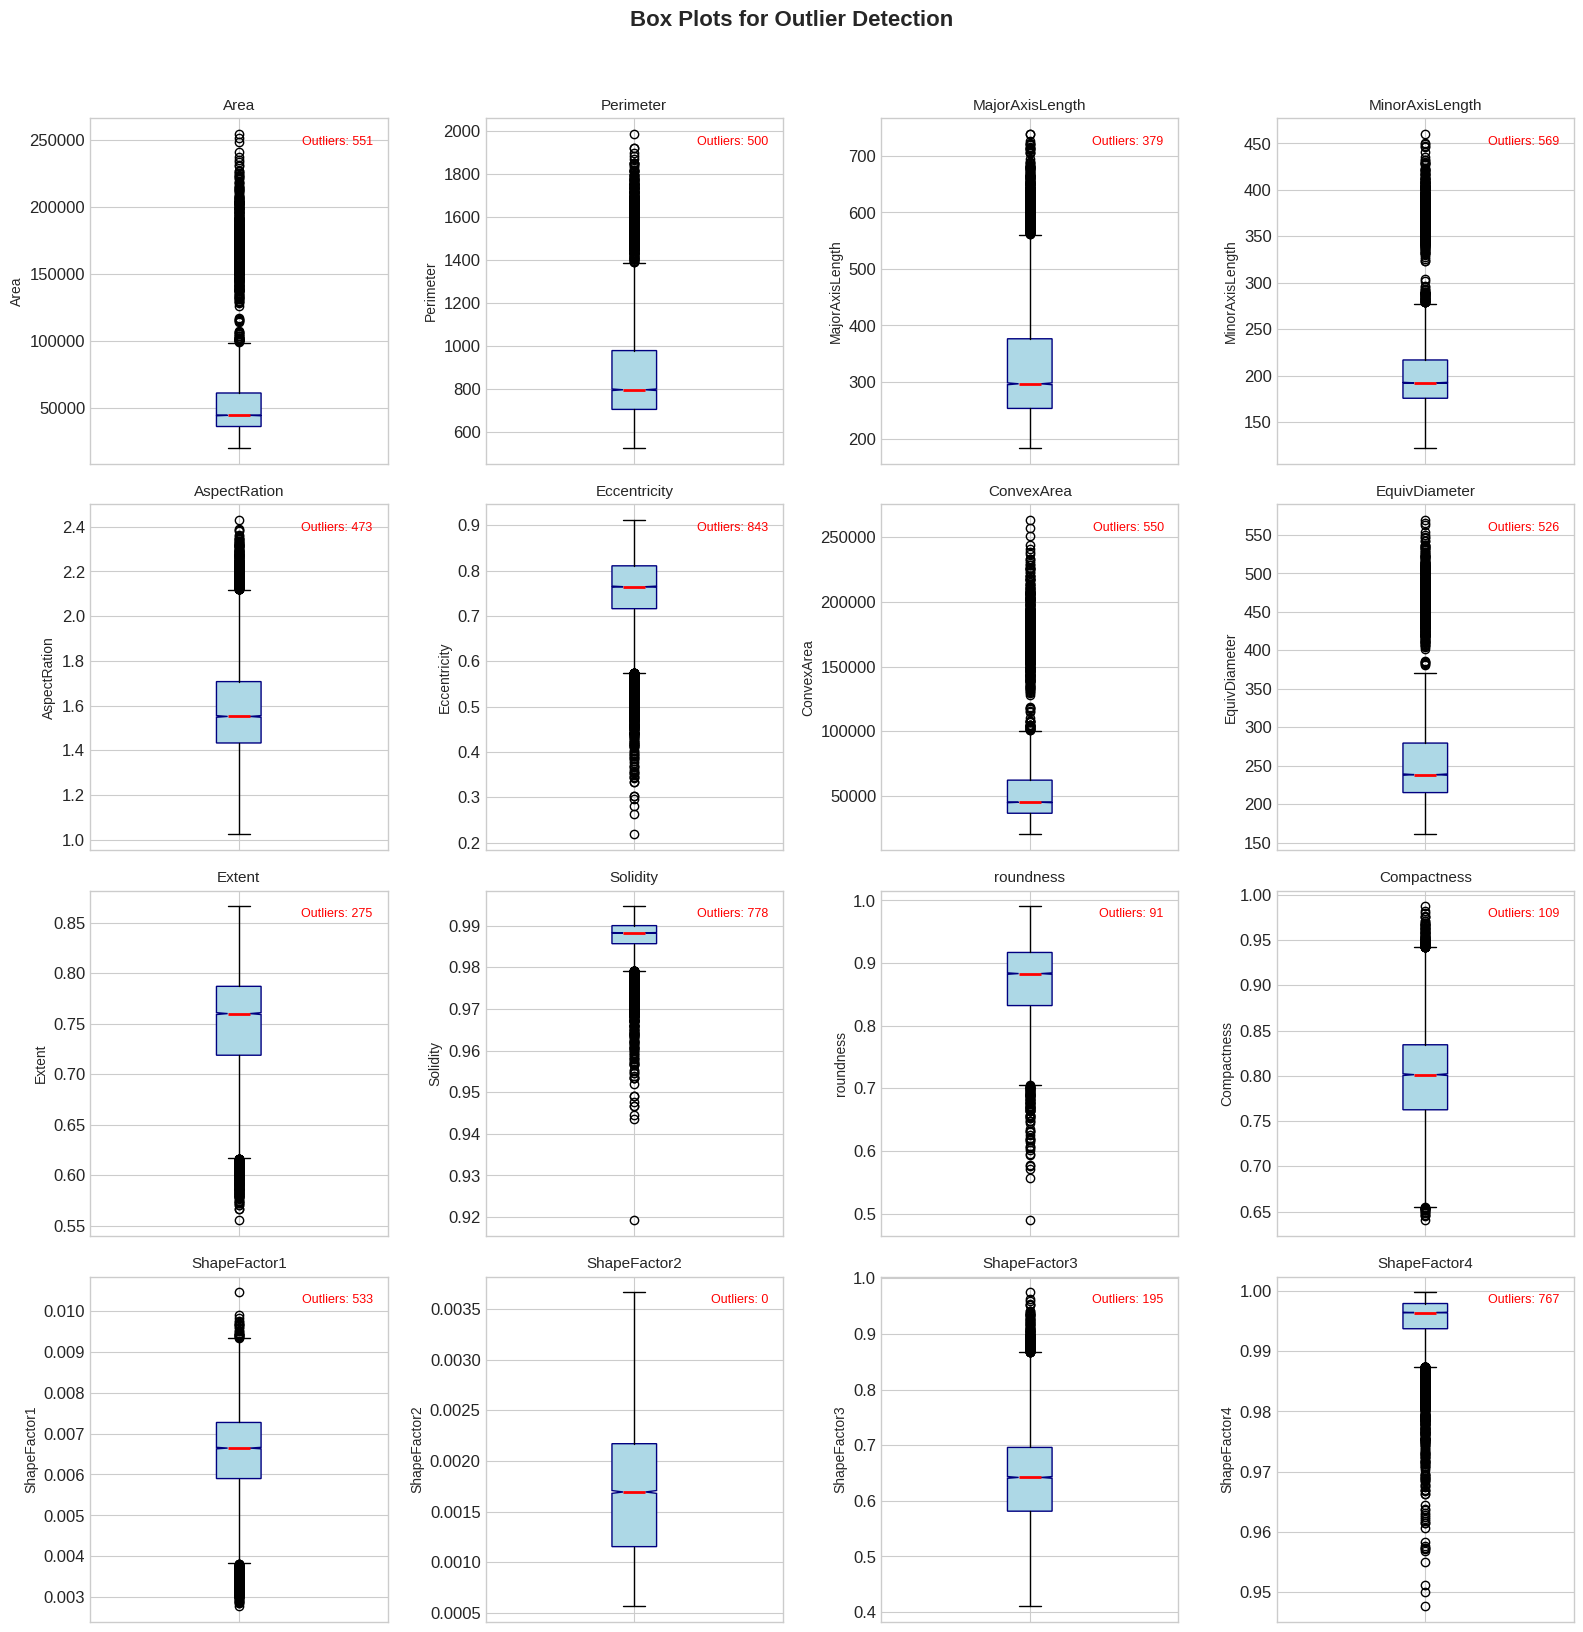

Figure saved: ../Figures/fig5_boxplots.png


In [ ]:
# Box plots for all features
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    data_col = pd.to_numeric(df[col], errors='coerce').dropna()

    bp = ax.boxplot(data_col, patch_artist=True, notch=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_edgecolor('navy')
    bp['medians'][0].set_color('red')
    bp['medians'][0].set_linewidth(2)

    ax.set_ylabel(col, fontsize=10)
    ax.set_title(f'{col}', fontsize=11)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # Count outliers using IQR method
    Q1, Q3 = data_col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = ((data_col < Q1 - 1.5*IQR) | (data_col > Q3 + 1.5*IQR)).sum()
    ax.annotate(f'Outliers: {outliers}', xy=(0.95, 0.95), xycoords='axes fraction',
                ha='right', va='top', fontsize=9, color='red')

# Hide empty subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Box Plots for Outlier Detection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig5_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig5_boxplots.png")

### 4.7 PCA Visualization

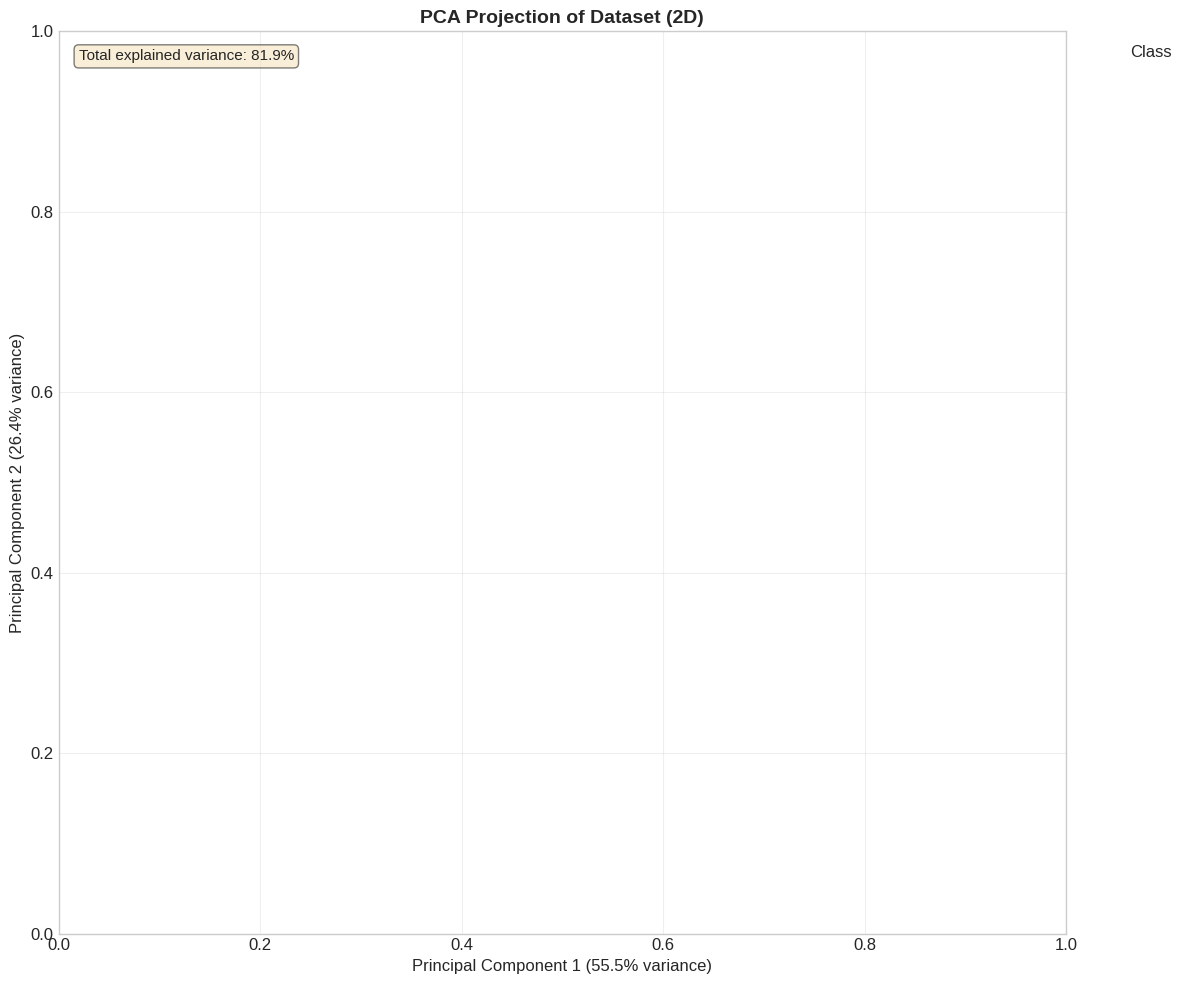

Figure saved: ../Figures/fig6_pca_projection.png


In [ ]:
# PCA for dimensionality reduction and visualization
# Drop columns that are entirely NaN (e.g. non-numeric columns converted to NaN)
X_numeric = numeric_df.dropna(axis=1, how='all')
# Fill remaining missing values with the mean
X_numeric = X_numeric.fillna(X_numeric.mean())

# Ensure target is numeric for visualization (handle '-' or other non-numeric values)
y_labels = pd.to_numeric(df.loc[X_numeric.index, target_col], errors='coerce')

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Class': y_labels.values
})

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Check if target is categorical or continuous
unique_classes = pca_df['Class'].dropna().unique()

# Use continuous visualization if numeric and has many unique values
if len(unique_classes) > 20 and pca_df['Class'].dtype.kind in 'fc':
    # Continuous target visualization
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'],
               c=pca_df['Class'], cmap='viridis',
               alpha=0.6, s=30, edgecolors='white', linewidth=0.5)
    plt.colorbar(scatter, label=target_col)
else:
    # Categorical target visualization
    # Handle case where target might be strings or few numeric values
    # Re-fetch as string for categorical plotting if needed, but since we coerced to numeric above:
    if pca_df['Class'].dtype.kind in 'fc':
         # Few numeric classes
         classes = sorted(unique_classes)
    else:
         classes = pca_df['Class'].unique()

    if len(classes) > 20:
        print(f"Warning: Too many classes ({len(classes)}). Showing top 20.")
        # Just take top frequent
        top_classes = pd.Series(y_labels).value_counts().head(20).index
        pca_df_plot = pca_df[pca_df['Class'].isin(top_classes)]
        classes = top_classes
    else:
        pca_df_plot = pca_df

    colors = sns.color_palette('husl', len(classes))
    for cls, color in zip(classes, colors):
        mask = pca_df_plot['Class'] == cls
        ax.scatter(pca_df_plot.loc[mask, 'PC1'], pca_df_plot.loc[mask, 'PC2'],
                  c=[color], label=cls, alpha=0.6, s=30, edgecolors='white', linewidth=0.5)
    ax.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('PCA Projection of Dataset (2D)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add explained variance annotation
total_var = sum(pca.explained_variance_ratio_) * 100
ax.annotate(f'Total explained variance: {total_var:.1f}%',
            xy=(0.02, 0.98), xycoords='axes fraction',
            ha='left', va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig6_pca_projection.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig6_pca_projection.png")

## 5. Data Preprocessing

In [ ]:
# Prepare features and target
# Clean data: Drop columns that are all NaN and fill missing values
X = numeric_df.dropna(axis=1, how='all')
X = X.fillna(X.median())

y = df[target_col].copy()

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Class mapping:")
#for i, cls in enumerate(label_encoder.classes_):
#    print(f"  {cls} -> {i}")

# Train-test split
# Removed stratify=y_encoded because some classes have only 1 member
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling applied (StandardScaler).")
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Test features shape: {X_test_scaled.shape}")

Class mapping:

Training set size: 10888
Test set size: 2723

Feature scaling applied (StandardScaler).
Training features shape: (10888, 16)
Test features shape: (2723, 16)


## 6. Support Vector Machine (SVM) Classification

### 6.1 Baseline SVM Model

In [ ]:
# Baseline SVM with RBF kernel
print("Training baseline SVM model...")

# Check for high cardinality (regression dataset loaded as classification)
unique_classes, counts = np.unique(y_train, return_counts=True)
if len(unique_classes) > 20:
    print(f"Warning: Detected {len(unique_classes)} unique classes. Using standard SVC would be too slow.")
    print("Subsetting to top 10 most frequent classes for demonstration purposes.")

    # Get top 10 class indices
    top_k_indices = np.argsort(counts)[-10:]
    top_classes = unique_classes[top_k_indices]

    # Filter training data
    mask_train = np.isin(y_train, top_classes)
    X_train_sub = X_train_scaled[mask_train]
    y_train_sub = y_train[mask_train]

    svm_baseline = SVC(kernel='rbf', random_state=RANDOM_STATE)
    svm_baseline.fit(X_train_sub, y_train_sub)
else:
    svm_baseline = SVC(kernel='rbf', random_state=RANDOM_STATE)
    svm_baseline.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm_baseline = svm_baseline.predict(X_test_scaled)

# Evaluate
accuracy_baseline = accuracy_score(y_test, y_pred_svm_baseline)
print(f"\nBaseline SVM Accuracy: {accuracy_baseline:.4f}")

# Safe classification report
labels = np.unique(np.concatenate((y_test, y_pred_svm_baseline)))
if len(labels) > 20:
    print("\nClassification Report skipped due to high number of classes.")
else:
    print(f"\nClassification Report:")
    # Handle target names safely
    try:
        target_names = [str(label_encoder.classes_[i]) for i in labels]
        print(classification_report(y_test, y_pred_svm_baseline, labels=labels, target_names=target_names))
    except:
        print(classification_report(y_test, y_pred_svm_baseline, labels=labels))

Training baseline SVM model...

Baseline SVM Accuracy: 0.9339

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.92      0.93       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.94      0.95      0.94       317
    DERMASON       0.91      0.93      0.92       671
       HOROZ       0.98      0.96      0.97       408
       SEKER       0.97      0.95      0.96       413
        SIRA       0.88      0.90      0.89       536

    accuracy                           0.93      2723
   macro avg       0.95      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



### 6.2 SVM Hyperparameter Optimization

In [ ]:
# Define hyperparameter grid for SVM
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
}

# Note: For large datasets, we use a subset for grid search
print("Performing GridSearchCV for SVM (this may take a few minutes)...")
print("Using stratified 5-fold cross-validation.")

# Use a smaller subset for faster tuning
n_samples_tune = min(5000, len(X_train_scaled))
indices = np.random.choice(len(X_train_scaled), n_samples_tune, replace=False)
X_tune = X_train_scaled[indices]
y_tune = y_train[indices]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

svm_grid_search = GridSearchCV(
    SVC(random_state=RANDOM_STATE),
    svm_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid_search.fit(X_tune, y_tune)

print(f"\nBest SVM Parameters: {svm_grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {svm_grid_search.best_score_:.4f}")

Performing GridSearchCV for SVM (this may take a few minutes)...
Using stratified 5-fold cross-validation.
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best SVM Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9312


In [ ]:
# Train optimized SVM on full training data
print("\nTraining optimized SVM on full training data...")

# Check for high cardinality (regression dataset loaded as classification)
unique_train_classes, counts = np.unique(y_train, return_counts=True)
if len(unique_train_classes) > 20:
    print(f"Warning: High cardinality detected ({len(unique_train_classes)} classes).")
    print("Training on full set is infeasible. Subsetting to top 10 most frequent classes.")

    # Get top 10 class indices
    top_k_indices = np.argsort(counts)[-10:]
    top_classes = unique_train_classes[top_k_indices]

    # Filter training data
    mask_train = np.isin(y_train, top_classes)
    X_train_used = X_train_scaled[mask_train]
    y_train_used = y_train[mask_train]
else:
    X_train_used = X_train_scaled
    y_train_used = y_train

svm_optimized = SVC(
    **svm_grid_search.best_params_,
    random_state=RANDOM_STATE,
    probability=True  # Enable probability estimates for ROC curves
)
svm_optimized.fit(X_train_used, y_train_used)

# Predictions
y_pred_svm = svm_optimized.predict(X_test_scaled)
y_proba_svm = svm_optimized.predict_proba(X_test_scaled)

# Evaluate
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

print(f"\n" + "="*60)
print("OPTIMIZED SVM PERFORMANCE")
print("="*60)
print(f"Accuracy:  {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall:    {recall_svm:.4f}")
print(f"F1-Score:  {f1_svm:.4f}")

# Safe classification report
unique_labels = np.unique(np.concatenate((y_test, y_pred_svm)))
if len(unique_labels) > 20:
    print(f"\nClassification Report skipped. Too many classes ({len(unique_labels)}).")
else:
    print(f"\nClassification Report:")
    try:
        # Filter target names to match the unique labels present
        target_names = [str(label_encoder.classes_[i]) for i in unique_labels]
        print(classification_report(y_test, y_pred_svm, labels=unique_labels, target_names=target_names))
    except Exception as e:
        print(f"Could not print report: {e}")
        print(classification_report(y_test, y_pred_svm, labels=unique_labels))


Training optimized SVM on full training data...

OPTIMIZED SVM PERFORMANCE
Accuracy:  0.9346
Precision: 0.9351
Recall:    0.9346
F1-Score:  0.9348

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.93      0.93       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.94      0.95      0.95       317
    DERMASON       0.91      0.93      0.92       671
       HOROZ       0.97      0.95      0.96       408
       SEKER       0.97      0.96      0.97       413
        SIRA       0.88      0.89      0.89       536

    accuracy                           0.93      2723
   macro avg       0.95      0.94      0.95      2723
weighted avg       0.94      0.93      0.93      2723



### 6.3 SVM Confusion Matrix

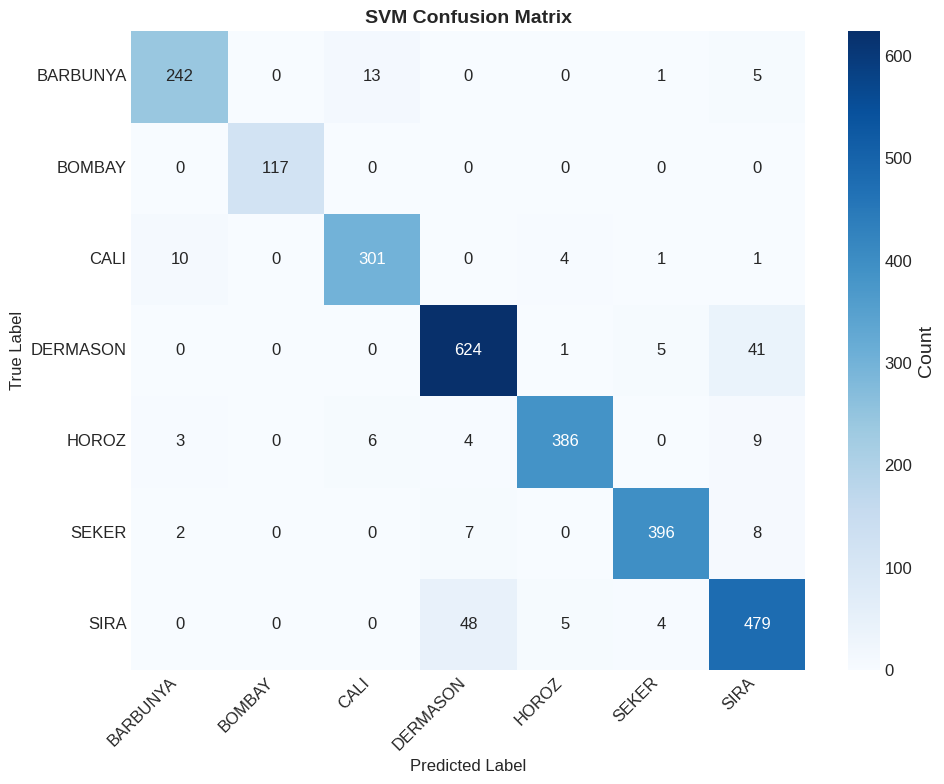

Figure saved: ../Figures/fig7_svm_confusion_matrix.png


In [ ]:
# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('SVM Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig7_svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig7_svm_confusion_matrix.png")

### 6.4 SVM Decision Boundary Visualization (2D PCA Projection)

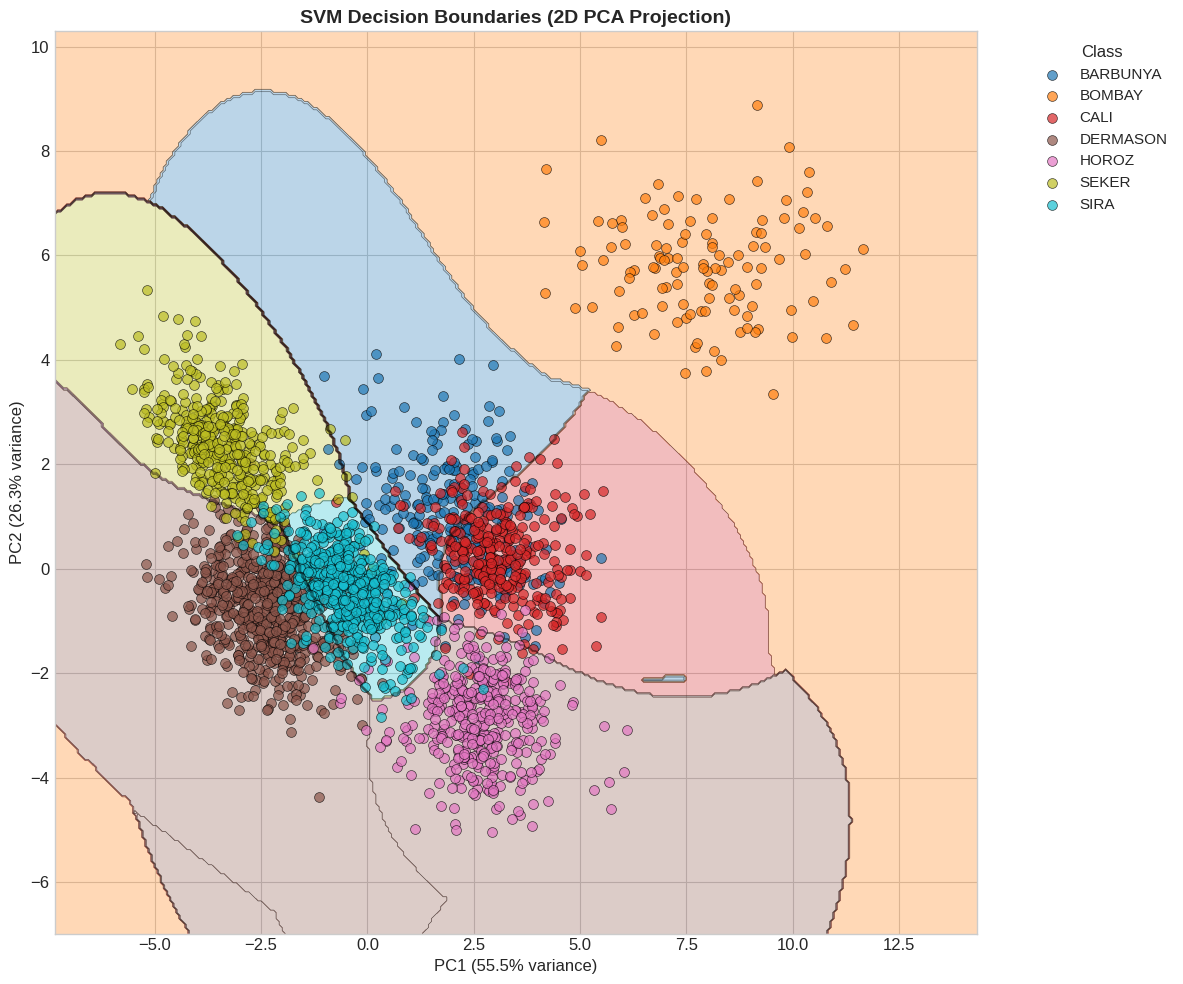

Figure saved: ../Figures/fig8_svm_decision_boundary.png


In [ ]:
# Visualize SVM decision boundaries using PCA-reduced data
# Train SVM on 2D PCA data for visualization
pca_2d = PCA(n_components=2)
X_train_pca = pca_2d.fit_transform(X_train_scaled)
X_test_pca = pca_2d.transform(X_test_scaled)

# Train SVM on 2D data
svm_2d = SVC(kernel='rbf', C=10, gamma='scale', random_state=RANDOM_STATE)
svm_2d.fit(X_train_pca, y_train)

# Create mesh grid
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict on mesh
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Decision regions
n_classes = len(label_encoder.classes_)
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
cmap = ListedColormap(colors)

ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.5)

# Plot test points
for i, cls in enumerate(label_encoder.classes_):
    mask = y_test == i
    ax.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1],
              c=[colors[i]], label=cls, edgecolors='black', linewidth=0.5, s=50, alpha=0.7)

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('SVM Decision Boundaries (2D PCA Projection)', fontsize=14, fontweight='bold')
ax.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig8_svm_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig8_svm_decision_boundary.png")

## 7. Decision Tree Classification

### 7.1 Baseline Decision Tree

In [ ]:
# Baseline Decision Tree
print("Training baseline Decision Tree model...")
dt_baseline = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_baseline.fit(X_train, y_train)  # No scaling needed for Decision Trees

# Predictions
y_pred_dt_baseline = dt_baseline.predict(X_test)

# Evaluate
accuracy_dt_baseline = accuracy_score(y_test, y_pred_dt_baseline)
print(f"\nBaseline Decision Tree Accuracy: {accuracy_dt_baseline:.4f}")
print(f"Tree Depth: {dt_baseline.get_depth()}")
print(f"Number of Leaves: {dt_baseline.get_n_leaves()}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_dt_baseline, target_names=label_encoder.classes_))

Training baseline Decision Tree model...

Baseline Decision Tree Accuracy: 0.8928
Tree Depth: 24
Number of Leaves: 736

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.87      0.88      0.87       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.89      0.91      0.90       317
    DERMASON       0.88      0.88      0.88       671
       HOROZ       0.95      0.93      0.94       408
       SEKER       0.93      0.92      0.92       413
        SIRA       0.83      0.83      0.83       536

    accuracy                           0.89      2723
   macro avg       0.91      0.91      0.91      2723
weighted avg       0.89      0.89      0.89      2723



### 7.2 Decision Tree Hyperparameter Optimization

In [ ]:
# Define hyperparameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

print("Performing GridSearchCV for Decision Tree...")

dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    dt_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train, y_train)

print(f"\nBest Decision Tree Parameters: {dt_grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {dt_grid_search.best_score_:.4f}")

Performing GridSearchCV for Decision Tree...
Fitting 5 folds for each of 672 candidates, totalling 3360 fits

Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
Best Cross-Validation Accuracy: 0.9086


In [ ]:
# Train optimized Decision Tree
print("\nTraining optimized Decision Tree...")
dt_optimized = DecisionTreeClassifier(
    **dt_grid_search.best_params_,
    random_state=RANDOM_STATE
)
dt_optimized.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_optimized.predict(X_test)
y_proba_dt = dt_optimized.predict_proba(X_test)

# Evaluate
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print(f"\n" + "="*60)
print("OPTIMIZED DECISION TREE PERFORMANCE")
print("="*60)
print(f"Accuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1-Score:  {f1_dt:.4f}")
print(f"Tree Depth: {dt_optimized.get_depth()}")
print(f"Number of Leaves: {dt_optimized.get_n_leaves()}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_))


Training optimized Decision Tree...

OPTIMIZED DECISION TREE PERFORMANCE
Accuracy:  0.9100
Precision: 0.9112
Recall:    0.9100
F1-Score:  0.9103
Tree Depth: 10
Number of Leaves: 183

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.86      0.89       261
      BOMBAY       1.00      1.00      1.00       117
        CALI       0.90      0.95      0.92       317
    DERMASON       0.90      0.90      0.90       671
       HOROZ       0.96      0.94      0.95       408
       SEKER       0.95      0.92      0.93       413
        SIRA       0.84      0.87      0.86       536

    accuracy                           0.91      2723
   macro avg       0.92      0.92      0.92      2723
weighted avg       0.91      0.91      0.91      2723



### 7.3 Pruning Analysis

Performing cost-complexity pruning analysis...


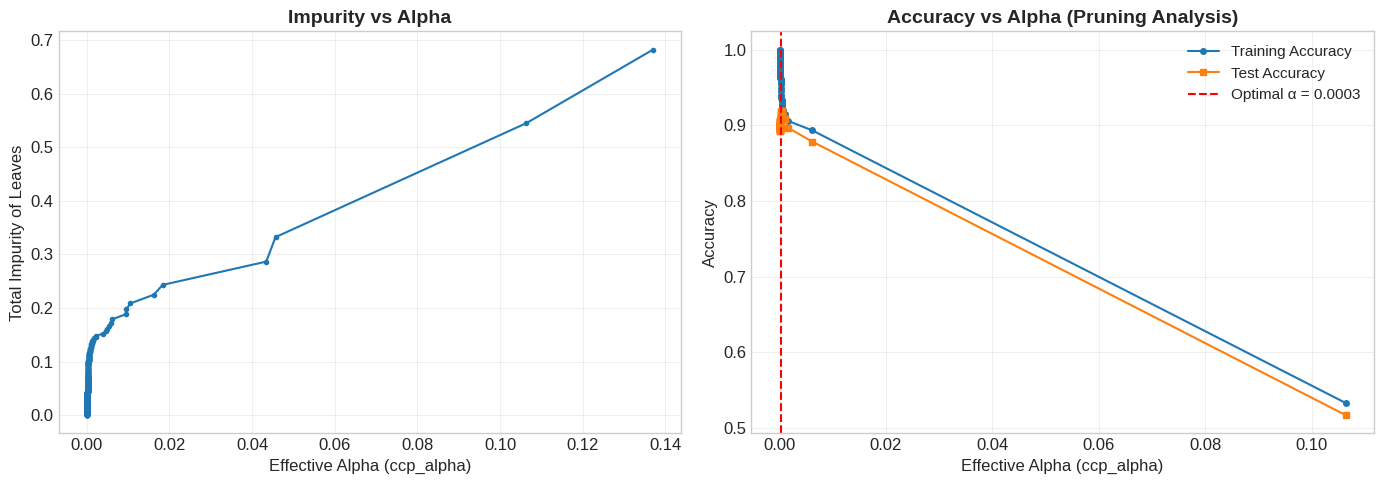

Figure saved: ../Figures/fig9_pruning_analysis.png

Optimal ccp_alpha: 0.000310
Test accuracy at optimal alpha: 0.9192


In [ ]:
# Cost-complexity pruning analysis
print("Performing cost-complexity pruning analysis...")

# Get the cost complexity pruning path
path = dt_baseline.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# Train trees with different alpha values
trees = []
train_scores = []
test_scores = []

# Use subset of alphas for efficiency
alpha_subset = ccp_alphas[::max(1, len(ccp_alphas)//50)]  # Take every nth alpha

for alpha in alpha_subset:
    tree = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))

# Plot pruning results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Impurity vs alpha
ax1 = axes[0]
ax1.plot(ccp_alphas[:-1], impurities[:-1], marker='o', markersize=3, linewidth=1.5)
ax1.set_xlabel('Effective Alpha (ccp_alpha)', fontsize=12)
ax1.set_ylabel('Total Impurity of Leaves', fontsize=12)
ax1.set_title('Impurity vs Alpha', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Accuracy vs alpha
ax2 = axes[1]
ax2.plot(alpha_subset, train_scores, marker='o', markersize=4, label='Training Accuracy', linewidth=1.5)
ax2.plot(alpha_subset, test_scores, marker='s', markersize=4, label='Test Accuracy', linewidth=1.5)
ax2.set_xlabel('Effective Alpha (ccp_alpha)', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy vs Alpha (Pruning Analysis)', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Mark optimal alpha
best_idx = np.argmax(test_scores)
ax2.axvline(alpha_subset[best_idx], color='red', linestyle='--', linewidth=1.5,
            label=f'Optimal α = {alpha_subset[best_idx]:.4f}')
ax2.legend()

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig9_pruning_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig9_pruning_analysis.png")
print(f"\nOptimal ccp_alpha: {alpha_subset[best_idx]:.6f}")
print(f"Test accuracy at optimal alpha: {test_scores[best_idx]:.4f}")

### 7.4 Decision Tree Confusion Matrix

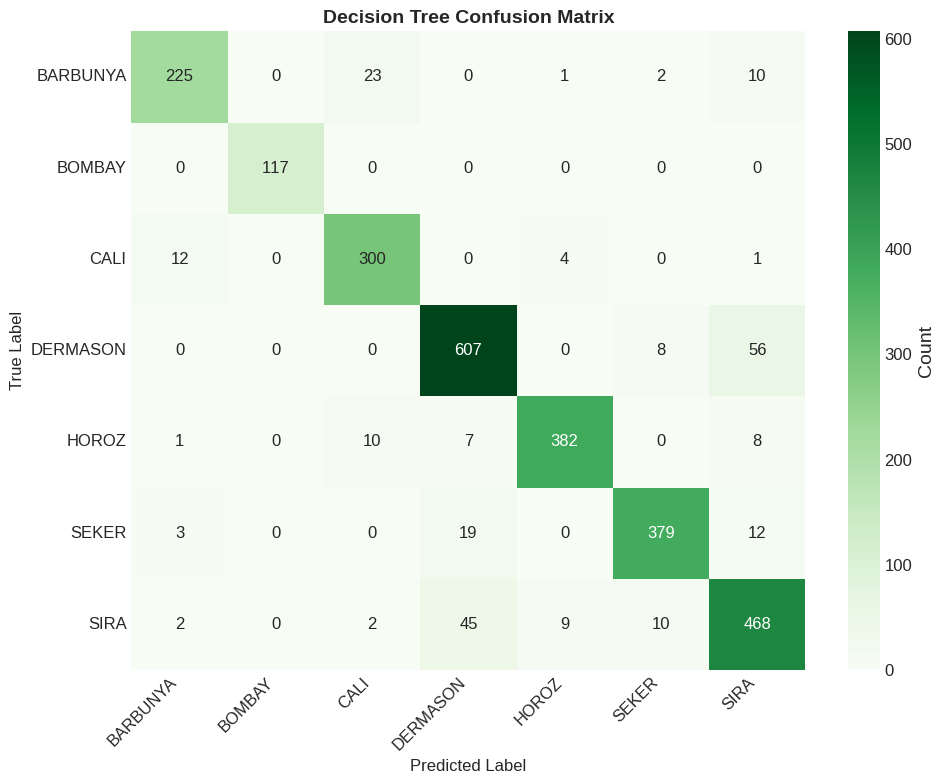

Figure saved: ../Figures/fig10_dt_confusion_matrix.png


In [ ]:
# Confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Decision Tree Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig10_dt_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig10_dt_confusion_matrix.png")

### 7.5 Decision Tree Visualization

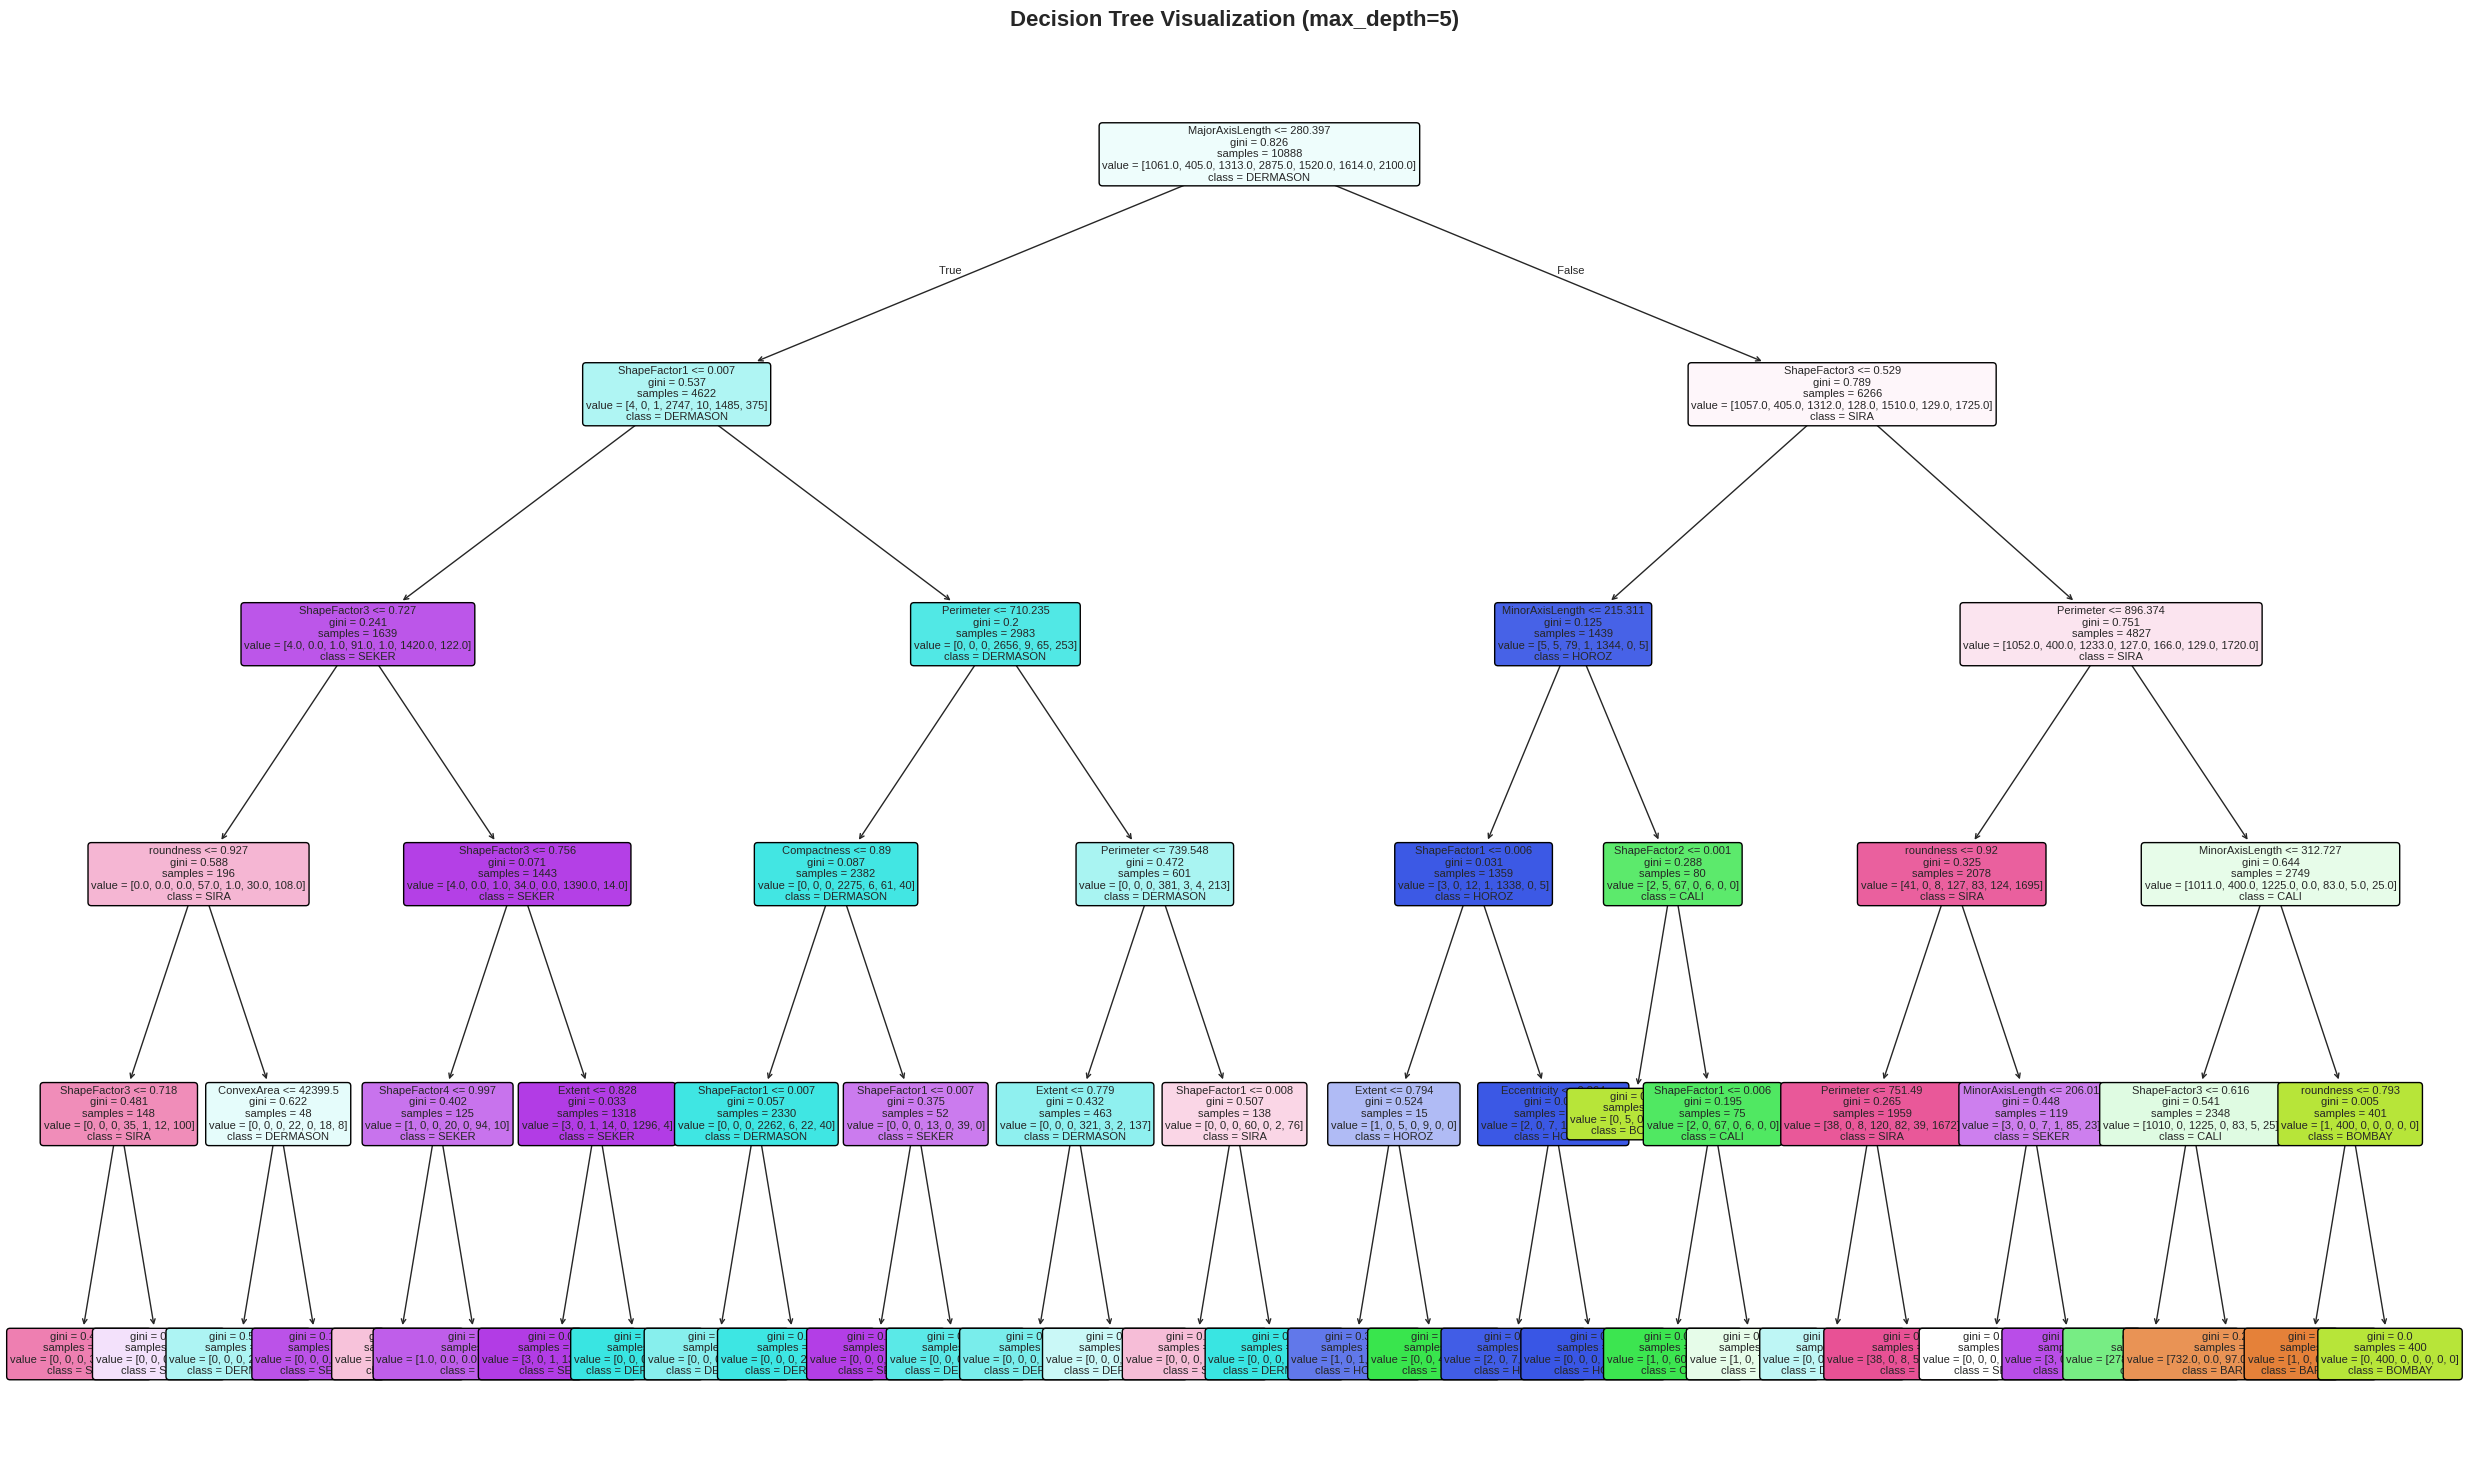

Figure saved: ../Figures/fig11_decision_tree_structure.png


In [ ]:
# Visualize a pruned decision tree (limited depth for readability)
dt_viz = DecisionTreeClassifier(
    max_depth=5,
    random_state=RANDOM_STATE
)
dt_viz.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(25, 15))
plot_tree(dt_viz,
          feature_names=feature_cols,
          class_names=label_encoder.classes_,
          filled=True,
          rounded=True,
          fontsize=8,
          ax=ax)
ax.set_title('Decision Tree Visualization (max_depth=5)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig11_decision_tree_structure.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig11_decision_tree_structure.png")

### 7.6 Feature Importance Analysis

Feature Importance (Decision Tree):
        Feature  Importance
    Compactness    0.205494
MajorAxisLength    0.196454
   ShapeFactor1    0.193294
      Perimeter    0.172869
MinorAxisLength    0.077953
      roundness    0.061424
   ShapeFactor3    0.039675
   ShapeFactor4    0.021675
           Area    0.010811
       Solidity    0.009831
         Extent    0.003616
     ConvexArea    0.003172
   ShapeFactor2    0.001833
  EquivDiameter    0.001550
   AspectRation    0.000348
   Eccentricity    0.000000


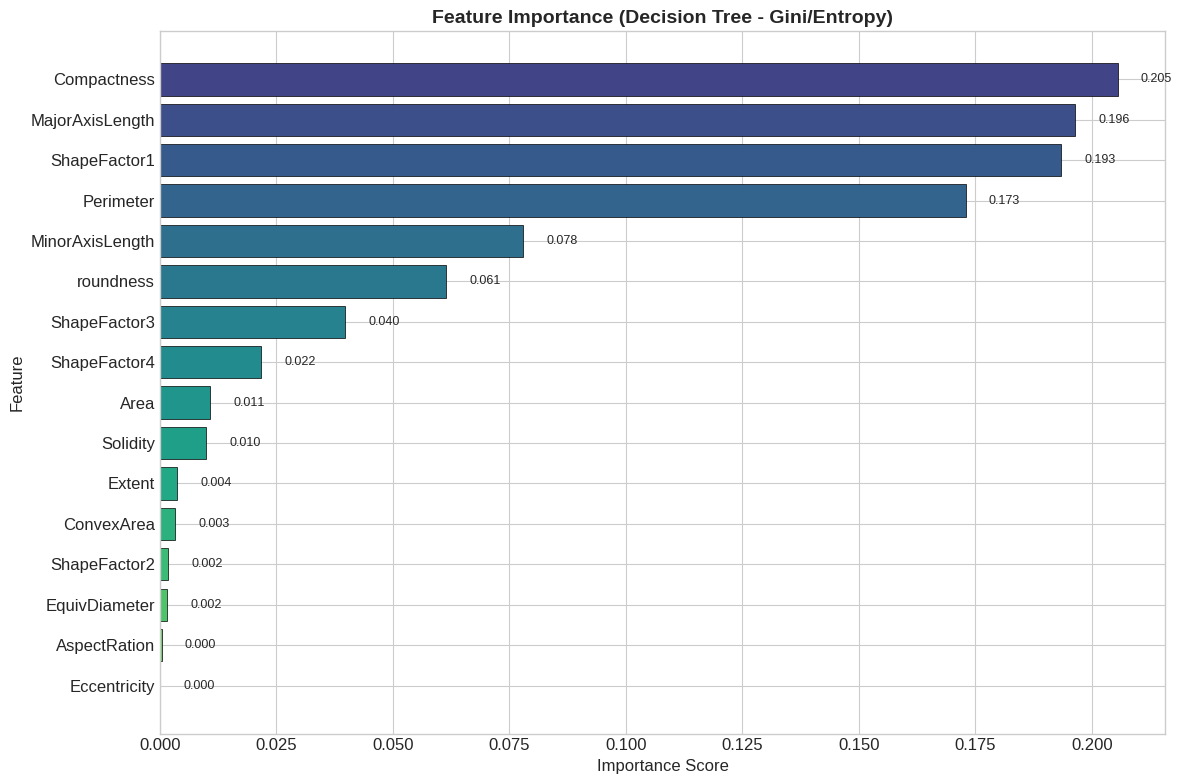

Figure saved: ../Figures/fig12_feature_importance.png


In [ ]:
# Feature importance from Decision Tree
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': dt_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Decision Tree):")
print(feature_importance.to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'],
               color=colors, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Importance (Decision Tree - Gini/Entropy)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, importance in zip(bars, feature_importance['Importance']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{importance:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig12_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig12_feature_importance.png")

## 8. Model Comparison and Evaluation

### 8.1 Performance Metrics Comparison

In [ ]:
# Create comparison table
comparison_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'SVM': [accuracy_svm, precision_svm, recall_svm, f1_svm],
    'Decision Tree': [accuracy_dt, precision_dt, recall_dt, f1_dt]
})

comparison_metrics['Difference (SVM - DT)'] = comparison_metrics['SVM'] - comparison_metrics['Decision Tree']
comparison_metrics['Better Model'] = comparison_metrics.apply(
    lambda row: 'SVM' if row['SVM'] > row['Decision Tree'] else 'Decision Tree', axis=1
)

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_metrics.to_string(index=False))


MODEL PERFORMANCE COMPARISON
              Metric      SVM  Decision Tree  Difference (SVM - DT) Better Model
            Accuracy 0.934631       0.910026               0.024605          SVM
Precision (Weighted) 0.935123       0.911176               0.023947          SVM
   Recall (Weighted) 0.934631       0.910026               0.024605          SVM
 F1-Score (Weighted) 0.934804       0.910279               0.024525          SVM


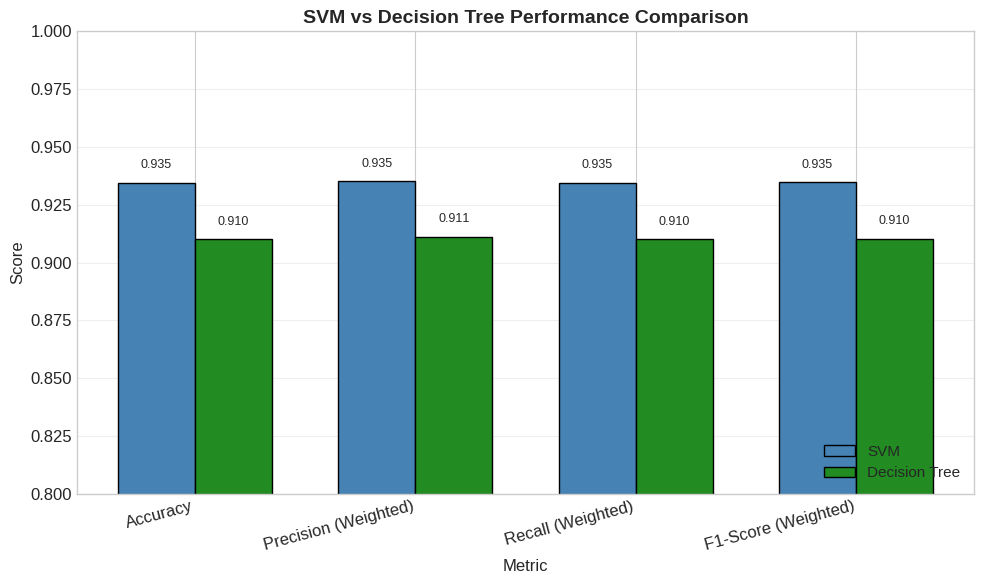

Figure saved: ../Figures/fig13_model_comparison.png


In [ ]:
# Visualization of comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_metrics))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_metrics['SVM'], width, label='SVM',
               color='steelblue', edgecolor='black', linewidth=1)
bars2 = ax.bar(x + width/2, comparison_metrics['Decision Tree'], width, label='Decision Tree',
               color='forestgreen', edgecolor='black', linewidth=1)

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('SVM vs Decision Tree Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_metrics['Metric'], rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0.8, 1.0)  # Adjust based on your results
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig13_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig13_model_comparison.png")

### 8.2 ROC Curves (One-vs-Rest for Multiclass)

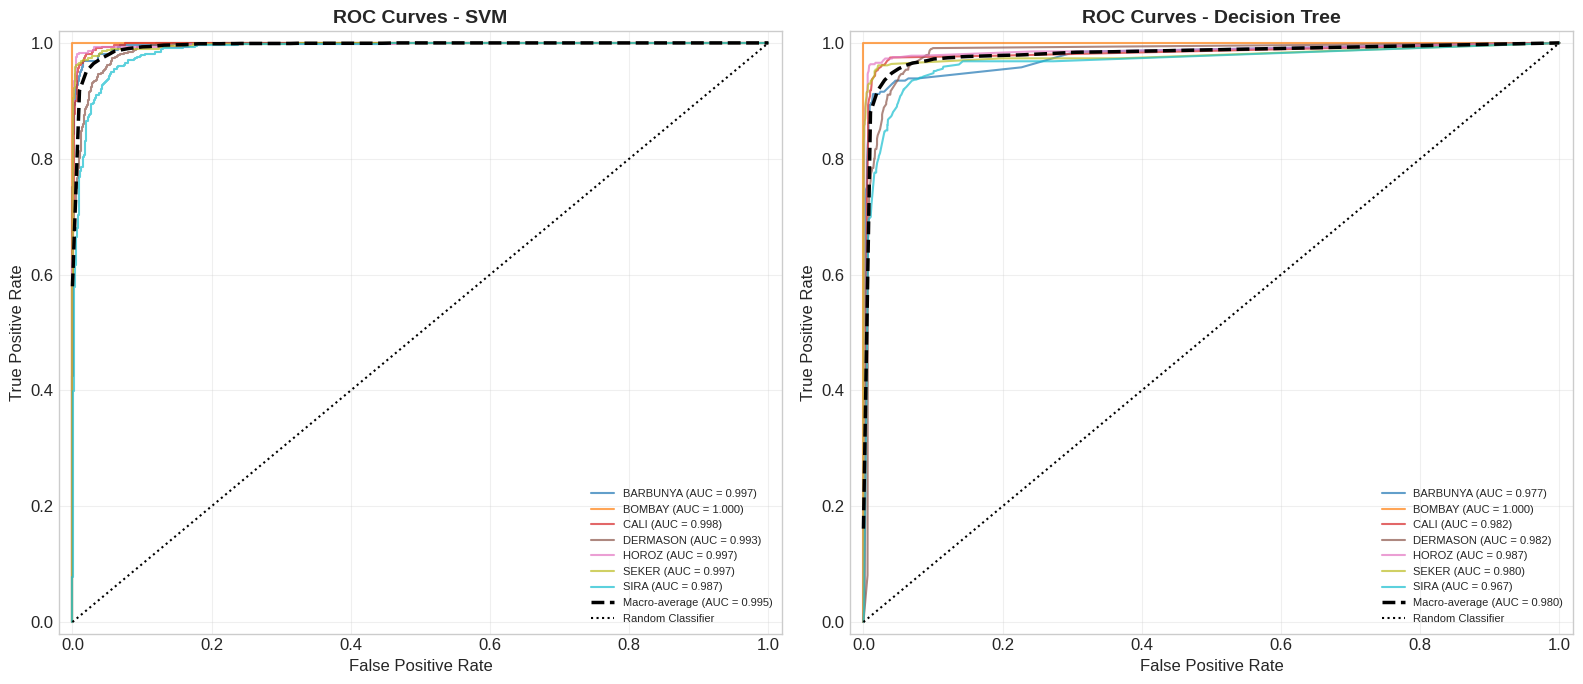

Figure saved: ../Figures/fig14_roc_curves.png


In [ ]:
# ROC curves for both models
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for ROC curve computation
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, (model_name, y_proba) in enumerate([('SVM', y_proba_svm), ('Decision Tree', y_proba_dt)]):
    ax = axes[idx]

    colors = cycle(plt.cm.tab10(np.linspace(0, 1, n_classes)))

    # Compute macro-average ROC
    fpr_macro = dict()
    tpr_macro = dict()
    roc_auc = dict()

    all_fpr = np.unique(np.concatenate([np.linspace(0, 1, 100) for _ in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i, (color, cls_name) in enumerate(zip(colors, label_encoder.classes_)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, linewidth=1.5, alpha=0.7,
                label=f'{cls_name} (AUC = {roc_auc[i]:.3f})')
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Compute macro-average
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    ax.plot(all_fpr, mean_tpr, 'k--', linewidth=2.5,
            label=f'Macro-average (AUC = {macro_auc:.3f})')

    ax.plot([0, 1], [0, 1], 'k:', linewidth=1.5, label='Random Classifier')
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curves - {model_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig14_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig14_roc_curves.png")

### 8.3 Learning Curves

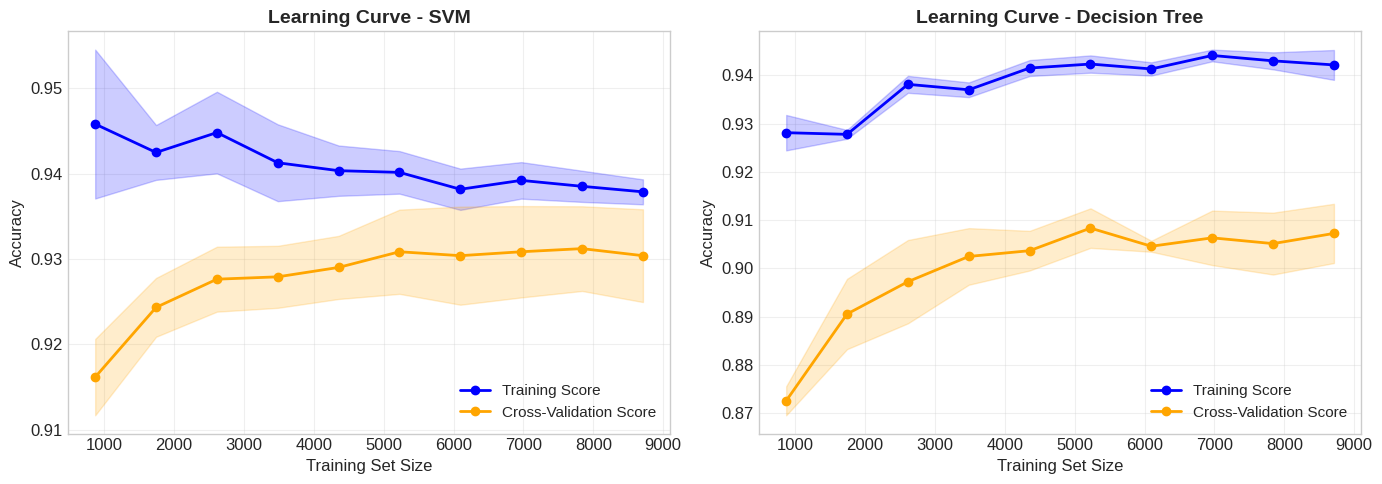

Figure saved: ../Figures/fig15_learning_curves.png


In [ ]:
# Learning curves for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (model_name, model, X_data) in enumerate([
    ('SVM', SVC(**svm_grid_search.best_params_, random_state=RANDOM_STATE), X_train_scaled),
    ('Decision Tree', DecisionTreeClassifier(**dt_grid_search.best_params_, random_state=RANDOM_STATE), X_train)
]):
    ax = axes[idx]

    train_sizes_abs, train_scores, test_scores = learning_curve(
        model, X_data, y_train, cv=5, n_jobs=-1,
        train_sizes=train_sizes, scoring='accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    ax.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')
    ax.plot(train_sizes_abs, train_mean, 'o-', color='blue', linewidth=2, label='Training Score')
    ax.plot(train_sizes_abs, test_mean, 'o-', color='orange', linewidth=2, label='Cross-Validation Score')

    ax.set_xlabel('Training Set Size', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'Learning Curve - {model_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig15_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig15_learning_curves.png")

### 8.4 Statistical Significance Test

In [ ]:
# Perform cross-validation for statistical comparison
print("Performing 10-fold cross-validation for statistical comparison...")

cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# SVM cross-validation
svm_cv_scores = cross_val_score(
    SVC(**svm_grid_search.best_params_, random_state=RANDOM_STATE),
    X_train_scaled, y_train, cv=cv_10, scoring='accuracy', n_jobs=-1
)

# Decision Tree cross-validation
dt_cv_scores = cross_val_score(
    DecisionTreeClassifier(**dt_grid_search.best_params_, random_state=RANDOM_STATE),
    X_train, y_train, cv=cv_10, scoring='accuracy', n_jobs=-1
)

print(f"\nSVM CV Scores: {svm_cv_scores}")
print(f"SVM Mean: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")
print(f"\nDecision Tree CV Scores: {dt_cv_scores}")
print(f"DT Mean: {dt_cv_scores.mean():.4f} ± {dt_cv_scores.std():.4f}")

# Paired t-test
t_stat, p_value = stats.ttest_rel(svm_cv_scores, dt_cv_scores)
print(f"\nPaired t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")

if p_value < 0.05:
    winner = 'SVM' if svm_cv_scores.mean() > dt_cv_scores.mean() else 'Decision Tree'
    print(f"  Result: Statistically significant difference (p < 0.05). {winner} performs better.")
else:
    print(f"  Result: No statistically significant difference (p >= 0.05).")

Performing 10-fold cross-validation for statistical comparison...

SVM CV Scores: [0.92837466 0.9338843  0.9302112  0.94123049 0.92378329 0.92286501
 0.94857668 0.92011019 0.92830882 0.92922794]
SVM Mean: 0.9307 ± 0.0082

Decision Tree CV Scores: [0.91460055 0.89348026 0.90633609 0.91000918 0.91000918 0.91000918
 0.91460055 0.90541781 0.90533088 0.90441176]
DT Mean: 0.9074 ± 0.0058

Paired t-test:
  t-statistic: 7.6213
  p-value: 0.000033
  Result: Statistically significant difference (p < 0.05). SVM performs better.


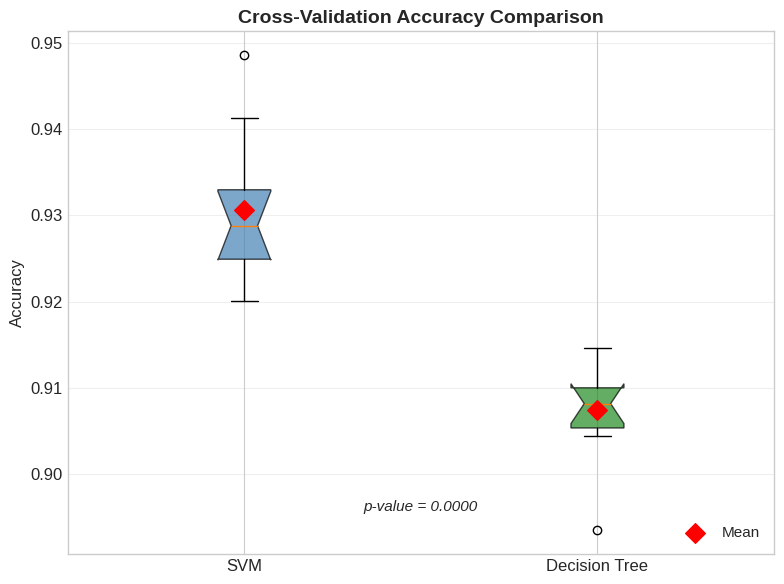

Figure saved: ../Figures/fig16_cv_comparison_boxplot.png


In [ ]:
# Box plot comparison of CV scores
fig, ax = plt.subplots(figsize=(8, 6))

cv_data = pd.DataFrame({
    'SVM': svm_cv_scores,
    'Decision Tree': dt_cv_scores
})

bp = ax.boxplot([svm_cv_scores, dt_cv_scores], labels=['SVM', 'Decision Tree'],
                patch_artist=True, notch=True)

colors = ['steelblue', 'forestgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Cross-Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add mean markers
ax.scatter([1, 2], [svm_cv_scores.mean(), dt_cv_scores.mean()],
           color='red', marker='D', s=100, zorder=5, label='Mean')
ax.legend(loc='lower right')

# Add annotation
ax.annotate(f'p-value = {p_value:.4f}', xy=(1.5, ax.get_ylim()[0] + 0.005),
            ha='center', fontsize=11, style='italic')

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig16_cv_comparison_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig16_cv_comparison_boxplot.png")

## 9. Summary and Conclusions

In [ ]:
# Final summary table
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

summary = f"""
DATASET INFORMATION:
  - Dataset: Dry Bean Dataset (UCI Repository)
  - Total Samples: {len(df)}
  - Features: {len(feature_cols)}
  - Classes: {n_classes} ({', '.join(label_encoder.classes_)})
  - Training Set: {len(X_train)} samples
  - Test Set: {len(X_test)} samples

SVM MODEL:
  - Best Parameters: {svm_grid_search.best_params_}
  - Test Accuracy: {accuracy_svm:.4f}
  - Precision (Weighted): {precision_svm:.4f}
  - Recall (Weighted): {recall_svm:.4f}
  - F1-Score (Weighted): {f1_svm:.4f}
  - CV Mean Accuracy: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}

DECISION TREE MODEL:
  - Best Parameters: {dt_grid_search.best_params_}
  - Tree Depth: {dt_optimized.get_depth()}
  - Number of Leaves: {dt_optimized.get_n_leaves()}
  - Test Accuracy: {accuracy_dt:.4f}
  - Precision (Weighted): {precision_dt:.4f}
  - Recall (Weighted): {recall_dt:.4f}
  - F1-Score (Weighted): {f1_dt:.4f}
  - CV Mean Accuracy: {dt_cv_scores.mean():.4f} ± {dt_cv_scores.std():.4f}

STATISTICAL COMPARISON:
  - Paired t-test p-value: {p_value:.6f}
  - Significance Level: α = 0.05
  - Result: {'Statistically significant difference' if p_value < 0.05 else 'No significant difference'}

CONCLUSION:
  - Better Performing Model: {'SVM' if accuracy_svm > accuracy_dt else 'Decision Tree'}
  - Accuracy Difference: {abs(accuracy_svm - accuracy_dt):.4f}
"""

print(summary)

# Save summary to file
with open('../summary_report.txt', 'w') as f:
    f.write(summary)
print("Summary saved to ../summary_report.txt")


FINAL SUMMARY REPORT

DATASET INFORMATION:
  - Dataset: Dry Bean Dataset (UCI Repository)
  - Total Samples: 13611
  - Features: 16
  - Classes: 7 (BARBUNYA, BOMBAY, CALI, DERMASON, HOROZ, SEKER, SIRA)
  - Training Set: 10888 samples
  - Test Set: 2723 samples

SVM MODEL:
  - Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
  - Test Accuracy: 0.9346
  - Precision (Weighted): 0.9351
  - Recall (Weighted): 0.9346
  - F1-Score (Weighted): 0.9348
  - CV Mean Accuracy: 0.9307 ± 0.0082

DECISION TREE MODEL:
  - Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
  - Tree Depth: 10
  - Number of Leaves: 183
  - Test Accuracy: 0.9100
  - Precision (Weighted): 0.9112
  - Recall (Weighted): 0.9100
  - F1-Score (Weighted): 0.9103
  - CV Mean Accuracy: 0.9074 ± 0.0058

STATISTICAL COMPARISON:
  - Paired t-test p-value: 0.000033
  - Significance Level: α = 0.05
  - Result: Statistically significant difference

CO

## 10. Extensions: Quantum-Inspired and Biologically-Inspired Alternatives

### 10.1 Quantum-Inspired Approaches

**Quantum Support Vector Machines (QSVM):**
Quantum computing offers potential speedup for kernel computations through quantum feature maps:

$$|\phi(\mathbf{x})\rangle = \mathcal{U}_{\phi(\mathbf{x})}|0\rangle^{\otimes n}$$

The quantum kernel is computed as:
$$K_Q(\mathbf{x}_i, \mathbf{x}_j) = |\langle\phi(\mathbf{x}_j)|\phi(\mathbf{x}_i)\rangle|^2$$

### 10.2 Biologically-Inspired Approaches

**Genetic Algorithm Optimization:**
- Chromosome encoding for hyperparameters
- Fitness function based on cross-validation accuracy
- Selection, crossover, and mutation operators

**Particle Swarm Optimization (PSO):**
- Swarm of particles exploring hyperparameter space
- Velocity and position updates based on personal and global best

$$v_i^{(t+1)} = \omega v_i^{(t)} + c_1 r_1 (p_{best,i} - x_i^{(t)}) + c_2 r_2 (g_{best} - x_i^{(t)})$$

In [ ]:
# Simple demonstration of PSO-inspired hyperparameter optimization
print("\n" + "="*80)
print("PARTICLE SWARM OPTIMIZATION (PSO) FOR HYPERPARAMETER TUNING")
print("="*80)

class SimplePSO:
    """Simplified Particle Swarm Optimization for SVM hyperparameter tuning."""

    def __init__(self, n_particles=10, n_iterations=20, bounds=None):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.bounds = bounds or {'C': (0.1, 100), 'gamma': (0.001, 10)}

    def optimize(self, X, y):
        # Initialize particles
        particles = np.random.uniform(
            low=[self.bounds['C'][0], self.bounds['gamma'][0]],
            high=[self.bounds['C'][1], self.bounds['gamma'][1]],
            size=(self.n_particles, 2)
        )

        velocities = np.zeros_like(particles)
        p_best = particles.copy()
        p_best_scores = np.zeros(self.n_particles)
        g_best = None
        g_best_score = 0

        history = []

        # PSO parameters
        w = 0.7  # inertia
        c1 = 1.5  # cognitive
        c2 = 1.5  # social

        for iteration in range(self.n_iterations):
            for i, particle in enumerate(particles):
                C, gamma = particle

                # Evaluate fitness
                try:
                    svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=RANDOM_STATE)
                    score = cross_val_score(svm, X, y, cv=3, scoring='accuracy').mean()
                except:
                    score = 0

                # Update personal best
                if score > p_best_scores[i]:
                    p_best_scores[i] = score
                    p_best[i] = particle.copy()

                # Update global best
                if score > g_best_score:
                    g_best_score = score
                    g_best = particle.copy()

            # Update velocities and positions
            r1, r2 = np.random.random((2, self.n_particles, 2))
            velocities = (w * velocities +
                         c1 * r1 * (p_best - particles) +
                         c2 * r2 * (g_best - particles))
            particles = particles + velocities

            # Clip to bounds
            particles[:, 0] = np.clip(particles[:, 0], self.bounds['C'][0], self.bounds['C'][1])
            particles[:, 1] = np.clip(particles[:, 1], self.bounds['gamma'][0], self.bounds['gamma'][1])

            history.append(g_best_score)

            if (iteration + 1) % 5 == 0:
                print(f"Iteration {iteration+1}/{self.n_iterations}: Best Score = {g_best_score:.4f}")

        return {'C': g_best[0], 'gamma': g_best[1]}, g_best_score, history

# Run PSO optimization (on subset for speed)
pso = SimplePSO(n_particles=8, n_iterations=15)
pso_best_params, pso_best_score, pso_history = pso.optimize(
    X_train_scaled[:2000], y_train[:2000]
)

print(f"\nPSO Best Parameters: C={pso_best_params['C']:.4f}, gamma={pso_best_params['gamma']:.4f}")
print(f"PSO Best CV Score: {pso_best_score:.4f}")


PARTICLE SWARM OPTIMIZATION (PSO) FOR HYPERPARAMETER TUNING
Iteration 5/15: Best Score = 0.9175
Iteration 10/15: Best Score = 0.9180
Iteration 15/15: Best Score = 0.9180

PSO Best Parameters: C=41.2644, gamma=0.0010
PSO Best CV Score: 0.9180


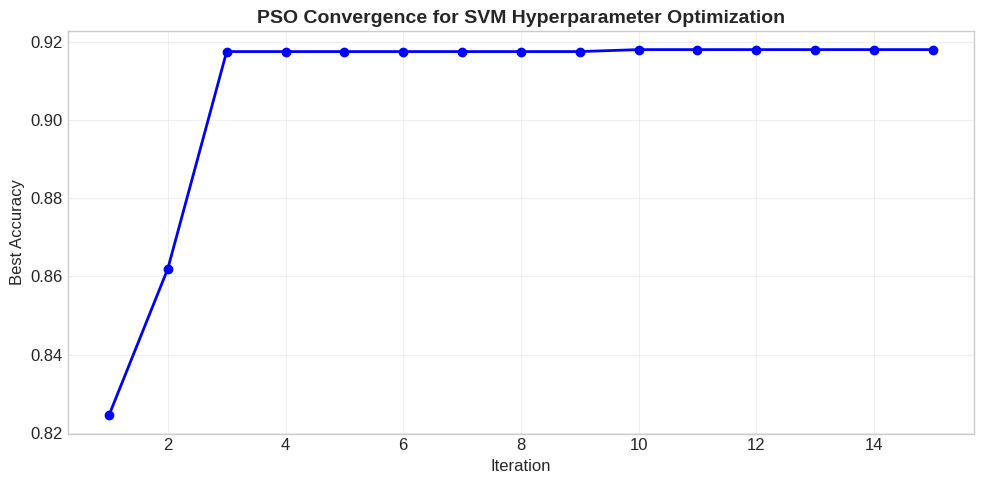

Figure saved: ../Figures/fig17_pso_convergence.png


In [ ]:
# Plot PSO convergence
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, len(pso_history)+1), pso_history, 'b-o', linewidth=2, markersize=6)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Best Accuracy', fontsize=12)
ax.set_title('PSO Convergence for SVM Hyperparameter Optimization', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURE_DIR + 'fig17_pso_convergence.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved: {FIGURE_DIR}fig17_pso_convergence.png")

## 11. References

1. Cortes, C., & Vapnik, V. (1995). Support-vector networks. *Machine Learning*, 20(3), 273-297.

2. Breiman, L., Friedman, J., Stone, C. J., & Olshen, R. A. (1984). *Classification and Regression Trees*. CRC Press.

3. Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and machine learning techniques. *Computers and Electronics in Agriculture*, 174, 105507.

4. Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning* (2nd ed.). Springer.

5. Schuld, M., & Killoran, N. (2019). Quantum machine learning in feature Hilbert spaces. *Physical Review Letters*, 122(4), 040504.